# Interpretting Energy Price Prediction in Spain

In [ ]:
# Run this cell if the following libraries are not installed
# !pip install --upgrade matplotlib
# !pip install pdpbox
# !pip install shap
# !pip install --upgrade alibi
# !pip install PyALE

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn
import xgboost as xgb
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import sys
# nb_path = "/content/drive/My Drive/Colab Notebooks/packages"
# if nb_path not in sys.path:
#   sys.path.insert(5, nb_path)

In [ ]:
common_path = '/content/drive/MyDrive/LMU/WS 2020 21/Spain Energy IML/'


In [ ]:
# !pip install -r requirements.txt --target="{nb_path}"

In [ ]:
# !pip install -U matplotlib --target="{nb_path}"

In [ ]:
# Loading required datasets
energy = pd.read_csv(common_path + "Data/energy_dataset.csv")
weather = pd.read_csv(common_path + "Data/weather_features.csv")

## Data Preprocessing

### Energy Data

Dropping all columns/features with zeros or NaNs and the TSO predictions

In [ ]:
energy = energy.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine', 'generation wind offshore', 'forecast wind offshore eday ahead','total load forecast', 'forecast solar day ahead','forecast wind onshore day ahead'], axis=1)

In [ ]:
energy.describe().round(2)
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

Using the time feature as an index and coverting to the required format

In [ ]:
energy['time'] = pd.to_datetime(energy['time'], utc=True, infer_datetime_format=True)
energy = energy.set_index('time')
# energy.head()

In [ ]:
energy.head()

generation biomass  ...  price actual
time                                           ...              
2014-12-31 23:00:00+00:00               447.0  ...         65.41
2015-01-01 00:00:00+00:00               449.0  ...         64.92
2015-01-01 01:00:00+00:00               448.0  ...         64.48
2015-01-01 02:00:00+00:00               438.0  ...         59.32
2015-01-01 03:00:00+00:00               428.0  ...         56.04

[5 rows x 17 columns]

In [ ]:
energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

We can see that most of the null values are in total load actual. We will shortly investigate and interpolate values.

In [ ]:
energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [ ]:
energy.isnull().sum(axis=0)
# energy.head()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

Our energy dataframe is now complete and ready to merge with weather data and feed into the model.

In [ ]:
energy.describe()

generation biomass  ...  price actual
count        35064.000000  ...  35064.000000
mean           383.531343  ...     57.884023
std             85.346266  ...     14.204083
min              0.000000  ...      9.330000
25%            333.000000  ...     49.347500
50%            367.000000  ...     58.020000
75%            433.000000  ...     68.010000
max            592.000000  ...    116.800000

[8 rows x 17 columns]

In [ ]:
# for feat in energy.columns:
#   print(feat, sum(energy[feat]))


### Weather Data

In [ ]:
# Stripping city names as Barcelona has trailing space in it
weather["city_name"] = list(map(str.strip, weather["city_name"]))

In [ ]:
weather.describe().round(2)

temp   temp_min   temp_max  ...    snow_3h  clouds_all  weather_id
count  178396.00  178396.00  178396.00  ...  178396.00   178396.00   178396.00
mean      289.62     288.33     291.09  ...       0.00       25.07      759.83
std         8.03       7.96       8.61  ...       0.22       30.77      108.73
min       262.24     262.24     262.24  ...       0.00        0.00      200.00
25%       283.67     282.48     284.65  ...       0.00        0.00      800.00
50%       289.15     288.15     290.15  ...       0.00       20.00      800.00
75%       295.15     293.73     297.15  ...       0.00       40.00      801.00
max       315.60     315.15     321.15  ...      21.50      100.00      804.00

[8 rows x 12 columns]

From an initial glance at all the variables in the weather dataset, we can see that 'pressure' and 'wind_speed' have very apparent outliers with respect to the other data. We will change the specific outlier values to NaN and interpolate new values in its place.

Also, since some of the column values are of a different type, we will standardise them to float64. We must also standardise the 'time' feature to match it with our energy dataset such that we can merge the two.

In [ ]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

# Convert columns with int64 type values to float64 type

weather = df_convert_dtypes(weather, np.int64, np.float64)

weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True, infer_datetime_format=True)
weather = weather.drop(['dt_iso'], axis=1)
weather = weather.set_index('time')

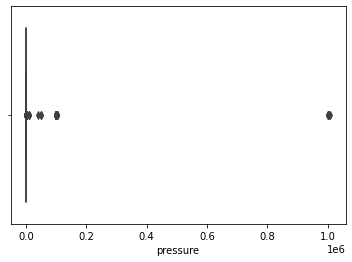

In [ ]:
import seaborn as sns
sns.boxplot(x=weather['pressure'])
plt.show()


In [ ]:
weather = weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

weather = weather.drop(['weather_main', 'weather_id', 'weather_description', 'weather_icon'], axis=1)


In [ ]:
weather.loc[weather.pressure > 1051, 'pressure'] = np.nan
weather.loc[weather.pressure < 931, 'pressure'] = np.nan
weather.loc[weather.wind_speed > 50, 'wind_speed'] = np.nan

weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)


Now that the weather data is complete we can proceed to merge it with energy dataset.

Distribute the weather dataset to 5 different tables each representing a distinct city. All further modeling and prediction happen for each city separately. 

In [ ]:
valencia = weather.loc[weather["city_name"]=="Valencia"]
seville = weather.loc[weather["city_name"]=="Seville"]
barcelona = weather.loc[weather["city_name"]=="Barcelona"]
bilbao = weather.loc[weather["city_name"]=="Bilbao"]
madrid = weather.loc[weather["city_name"]=="Madrid"]
city_dfs = [valencia,seville,barcelona, bilbao, madrid]

### Merge and Prepare

Can include or exclude TSO prediction as input features to our model. It helps improve prediction accuracy but overpowers the effect of the other features in the dataset. By default we will exclude the feature 'price day ahead' in our model training, but use it later to compare results of our model to the TSO predictions.

To include 'price day ahead', set the variable 'no forecast' to **true**.

This section prepares the Train, Test and Validation sets for model input.

In [ ]:
df_final = energy

for df in city_dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Valencia', 'snow_3h_Seville',
                          'snow_3h_Bilbao', 'snow_3h_Madrid'], axis=1)    

df_final.head()

generation biomass  ...  clouds_all_Madrid
time                                           ...                   
2014-12-31 23:00:00+00:00               447.0  ...                0.0
2015-01-01 00:00:00+00:00               449.0  ...                0.0
2015-01-01 01:00:00+00:00               448.0  ...                0.0
2015-01-01 02:00:00+00:00               438.0  ...                0.0
2015-01-01 03:00:00+00:00               428.0  ...                0.0

[5 rows x 67 columns]

In [ ]:
df_final.describe()

generation biomass  ...  clouds_all_Madrid
count        35064.000000  ...       35064.000000
mean           383.531343  ...          20.661334
std             85.346266  ...          29.656482
min              0.000000  ...           0.000000
25%            333.000000  ...           0.000000
50%            367.000000  ...           0.000000
75%            433.000000  ...          40.000000
max            592.000000  ...         100.000000

[8 rows x 67 columns]

In [ ]:
y_train = df_final['price actual']
X_train = df_final.drop(['price actual'], axis=1)

classification = False

# Toggle to false if required
no_forecast = True

In [ ]:
#ACHTUNG: Only run this cell if you want to convert to classification problem
if classification:
    y_train = pd.qcut(df_final['price actual'], 20, labels=False)
    print(y_train)
    classification = True

In [ ]:
# ACHTUNG: run this cell only if you don't want predictions in the model input. It is the best feature.
if no_forecast:
    X_train = X_train.drop(['price day ahead'], axis=1)
    print('Dropped Forecast')
    no_forecast = True

Dropped Forecast


In [ ]:
corr_matrix = X_train.corr()

In [ ]:
corr_matrix

generation biomass  ...  clouds_all_Madrid
generation biomass                              1.000000  ...          -0.054757
generation fossil brown coal/lignite            0.230039  ...          -0.038923
generation fossil gas                          -0.021520  ...          -0.023890
generation fossil hard coal                     0.433734  ...          -0.055442
generation fossil oil                           0.459584  ...          -0.051446
...                                                  ...  ...                ...
wind_speed_Madrid                              -0.046603  ...           0.220297
wind_deg_Madrid                                 0.019205  ...           0.034258
rain_1h_Madrid                                 -0.032977  ...           0.340360
rain_3h_Madrid                                  0.030141  ...           0.040133
clouds_all_Madrid                              -0.054757  ...           1.000000

[65 rows x 65 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
usable_features = list(X_train.columns)

Now that the data is ready to feed into the models, we want to compare predictions made by the TSO to the actual price.

In [ ]:
if not no_forecast:
    if classification:
        TSO_pred = pd.qcut(X_test["price day ahead"], 20, labels=False)
    else:
        TSO_pred = X_test["price day ahead"]
    print(TSO_pred)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


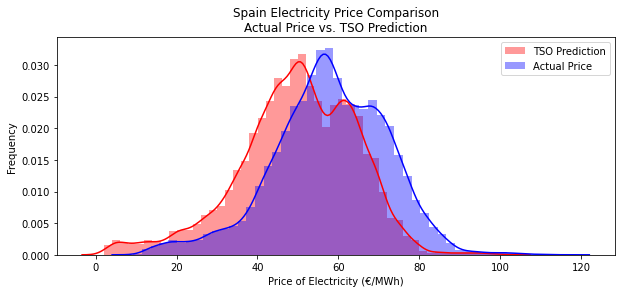

In [ ]:
# sns.set_color_codes(palette='deep')
sns.color_palette()
blue= '#30b4c9'
red= '#f25c5c'
green= '#69b64f'
yellow= '#f6ab53'
purple ='#ad85d2'

# ‘b’, ‘g’, ‘r’, ‘c’, ‘m’, ‘y’, ‘k’, ‘w’

plt.figure(figsize=(10,4))
gr = sns.distplot(df_final['price day ahead'], bins=50, label='TSO Prediction',color='r')
gr = sns.distplot(df_final['price actual'], bins=50, label='Actual Price',color='b')


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
gr.set_title('Spain Electricity Price Comparison\nActual Price vs. TSO Prediction')
plt.legend()
plt.show()

# p_diff = df['price actual'] - df['price day ahead']

# plt.figure(figsize=(10,4))
# gr = sns.distplot(p_diff, bins=50, label='Actual Price minus TSO Prediction',color='r')
# gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
# gr.set_title('Spain Electricity Price\nDifference Between Actual Price and TSO Prediction')
# plt.legend()
# plt.show()

## Model Selection

### Linear Regression

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_lr = model.predict(X_test)

In [ ]:
# print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Linear Regression Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred_lr))
# print('TSO Mean squared error (MSE): %.2f'
      # % mean_squared_error(y_test, TSO_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred_lr))

Intercept: -348.7025986100751
Linear Regression Mean squared error (MSE): 97.12
Coefficient of determination (R^2): 0.52


### XGBoost

In [ ]:
if classification:
    xgb_model = xgb.XGBClassifier( verbosity=0, n_jobs=1, min_child_weight=0.1, max_depth=100)
else:
    xgb_model = xgb.XGBRegressor(objective='reg:linear', verbosity=0, n_jobs=1, min_child_weight=0.1, max_depth=100)
print(xgb_model)

# xgb_regressor.fit()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=100, min_child_weight=0.1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)


In [ ]:
# xgb_model.fit(X_train.values, y_train.values)

# y_pred_xg = xgb_model.predict(X_test.values)

In [ ]:
xgb_model.fit(X_train, y_train)

y_pred_xg = xgb_model.predict(X_test)

In [ ]:
mse=mean_squared_error(y_test, y_pred_xg)

print('Mean Squared Error (MSE) for XGBoost is: {}'.format(mse))

print("R^2 score of the model on validation data: ", xgb_model.score(X_test, y_test))

Mean Squared Error (MSE) for XGBoost is: 19.760388847517834
R^2 score of the model on validation data:  0.9025670965107905


Mean Squared Error (MSE) for XGBoost is: 24.588813193627505

R^2 score of the model on validation data:  0.8706153731729882

### Gradient Boosting Regressor

In [ ]:
grad_boost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=100, random_state=0, loss='ls').fit(X_train, y_train)

grad_boost.fit(X_train.values, y_train.values)

y_pred_grad = grad_boost.predict(X_test.values)

In [ ]:
mse=mean_squared_error(y_test, y_pred_grad)

print('Mean Squared Error (MSE) for Gradient Boost is: {}'.format(mse))

# print("R^2 score of the model on validation data: ", grad_boost.score(X_val.values, y_val.values))

Mean Squared Error (MSE) for Gradient Boost is: 61.306217998469606


### Random Forest Regressor

In [ ]:
rand_forest_reg = RandomForestRegressor(n_estimators=100,max_depth=100, random_state=0).fit(X_train, y_train)

rand_forest_reg.fit(X_train.values, y_train.values)

y_pred_rand = rand_forest_reg.predict(X_test.values)

In [ ]:
mse=mean_squared_error(y_test, y_pred_rand)

print('Mean Squared Error (MSE) for Random Forest Regressor is: {}'.format(mse))

print("R^2 score of the model on validation data: ", rand_forest_reg.score(X_test, y_test))

### Comparison of all models
Comparing the inherently interpretable Linear Regression model, XGBoost model and the predictions made by Spanish TSO Red Electric España. 

By comparing the Mean Squared Error and the R^2 score for all models, we can see that XGBoost and Random Forrest is similar, but XGboost is marginally better. We will further visualize their outputs and choose a model.

In [ ]:

diffs_xg = y_test - y_pred_xg
# diffs_tso = y_test - TSO_pred
diffs_LR = y_test - y_pred_lr
diffs_grad = y_test - y_pred_grad
diffs_rand = y_test - y_pred_rand
data_to_plot = [diffs_xg, diffs_LR, diffs_grad, diffs_rand]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.set_title('Distribution of Residuals for XGBoost, Linear Regression, Gradient Boost and Random Forest')

labels = ['XGBoost', 'Linear Regression', 'Gradient Boost', 'Random Forrest']

# Create the boxplot
bp = ax.boxplot(data_to_plot, labels=labels, showfliers=False)

In this graphic we can clearly see that the XGBoost model is fairly accurate and much better than the TSO predictions and all our other models.

In [ ]:
# ‘b’, ‘g’, ‘r’, ‘c’, ‘m’, ‘y’, ‘k’, ‘w’

plt.figure(figsize=(10,4))
# gr = sns.distplot(TSO_pred, bins=50, label='TSO Prediction',color='r')
gr = sns.distplot(y_test, bins=50, label='Actual Price',color='blue')
gr = sns.distplot(y_pred_xg, bins=50, label='XGBoost',color='black')


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
gr.set_title('Spain Electricity Price Comparison\nActual Price vs XGBoost')
plt.legend()
plt.show()

## Model Agnosting Interpretation

### Chosen model: XGB Regressor

In [ ]:
final_model = xgb_model

In [ ]:
#Interpretation related Librarires
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn_gbmi import *
from pdpbox import pdp
from collections import defaultdict
# from alibi.explainers import ALE, plot_ale
from PyALE import ale
# import shap
from anchor import utils, anchor_tabular
import itertools
import math
from matplotlib.gridspec import GridSpec
from pdpbox.pdp_calc_utils import _calc_ice_lines_inter
from pdpbox.pdp import pdp_isolate, PDPInteract
from pdpbox.utils import (_check_model, _check_dataset, _check_percentile_range, _check_feature,
                    _check_grid_type, _check_memory_limit, _make_list,
                    _calc_memory_usage, _get_grids, _get_grid_combos, _check_classes)
from joblib import Parallel, delayed

### Utils/ Helper functions

In [ ]:
cities = ['Barcelona', 'Madrid', 'Seville', 'Bilbao', 'Valencia']

In [ ]:
def get_weather_for_cities(feat):
  return ["{}_{}".format(feat, city) for city in cities]

In [ ]:
def get_indices_of_features(input_feat):
    indices = []
    for feat in input_feat:
        if feat in weather.columns:
            print(feat)
            city_feat = [usable_features.index(feat + '_{}'.format(city)) for city in ['Barcelona', 'Valencia', 'Madrid', 'Seville', 'Bilbao']]
            indices.extend(city_feat)
        else:
            re = [usable_features.index(feat)]
            indices.extend(re)
    return indices

### 1. Which features are most important? 
Method used: Permutation Feature Importance, Accumulated Local Effects (ALE)

Note: Can be run on training data or validation data.

https://scikit-learn.org/stable/modules/permutation_importance.html

#### Ensemble model feature importance

In [ ]:
# To get average feature feature importances
def get_top_features(model):
  all_scores = []
  for i in range(10):
    model.fit(X_train.values, y_train.values)
    all_scores.append(final_model.feature_importances_)

  np_scores = np.array(all_scores)
  avg_scores = np.average(np_scores, axis=0)
  sorted_idx = avg_scores.argsort()[::-1]
  top_10_idx = sorted_idx[:10]
  top_features_scores = [avg_scores[feat] for feat in top_10_idx]
  top_features = [usable_features[feat] for feat in top_10_idx]
  return top_features, top_features_scores


In [ ]:
def plot_top_10_features(features, importance_scores, title):
  y_ticks = np.arange(0, len(features))
  fig, ax = plt.subplots()
  ax.barh(y_ticks, importance_scores)
  ax.set_yticklabels(features)
  ax.set_yticks(y_ticks)
  ax.set_title(title)
  fig.tight_layout()
  plt.show()

In [ ]:
top_features_xg, top_features_scores_xg = get_top_features(final_model)

In [ ]:
for i in range(10):
  print('{} : {}'.format(top_features_xg[i], top_features_scores_xg[i]))

NameError: ignored

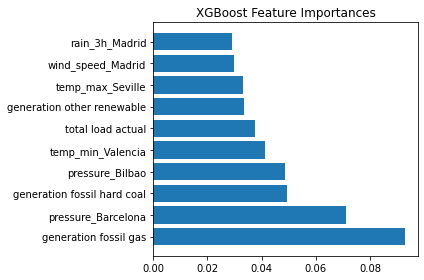

In [ ]:
plot_top_10_features(top_features_xg, top_features_scores_xg, 'XGBoost Feature Importances')

#### Permutation Feature Importance

In [ ]:
print("R^2 score of the model on validation data: ", final_model.score(X_val.values, y_val.values))
print()
r = permutation_importance(final_model, X_test.values, y_test.values, n_repeats=10, random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{usable_features[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

R^2 score of the model on validation data:  0.8539001776975539



In [ ]:
top_features_pfi = []
top_features_scores_pfi = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        top_features_pfi.append(usable_features[i])
        top_features_scores_pfi.append(r.importances_mean[i])
        print(f"{usable_features[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

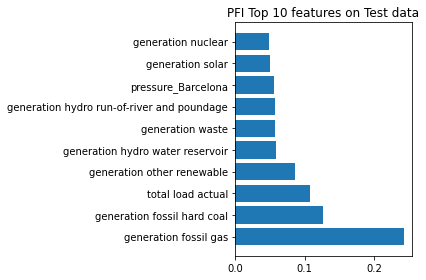

In [ ]:
title = 'PFI Top 10 features on Test data'
plot_top_10_features(top_features_pfi[:10], top_features_scores_pfi[:10], title)

generation fossil gas0.261 +/- 0.004

total load actual0.128 +/- 0.001

generation fossil hard coal0.121 +/- 0.001

generation other renewable0.094 +/- 0.001

generation hydro water reservoir0.061 +/- 0.001

pressure_Barcelona0.060 +/- 0.001

generation hydro pumped storage consumption0.054 +/- 0.001

generation hydro run-of-river and poundage0.050 +/- 0.001

generation solar0.045 +/- 0.001

generation waste0.045 +/- 0.001

pressure_Bilbao0.035 +/- 0.001

generation nuclear0.034 +/- 0.000

generation other0.030 +/- 0.000

temp_max_Seville0.029 +/- 0.001

generation biomass0.022 +/- 0.000

generation wind onshore0.018 +/- 0.000

temp_min_Valencia0.018 +/- 0.000

wind_speed_Madrid0.018 +/- 0.000

generation fossil brown coal/lignite0.018 +/- 0.000

generation fossil oil0.016 +/- 0.000

temp_min_Barcelona0.010 +/- 0.000

humidity_Valencia0.010 +/- 0.000

pressure_Madrid0.010 +/- 0.000

temp_max_Valencia0.010 +/- 0.000

#### Accumulated Local Effects (ALE)

Documentation: https://docs.seldon.io/projects/alibi/en/stable/methods/ALE.html

In [ ]:
# from alibi import ALE, plot_ale

ale = ALE(final_model.predict, feature_names=top_features, target_names=['price actual'])
xg_ale = ale.explain(X_train.values)

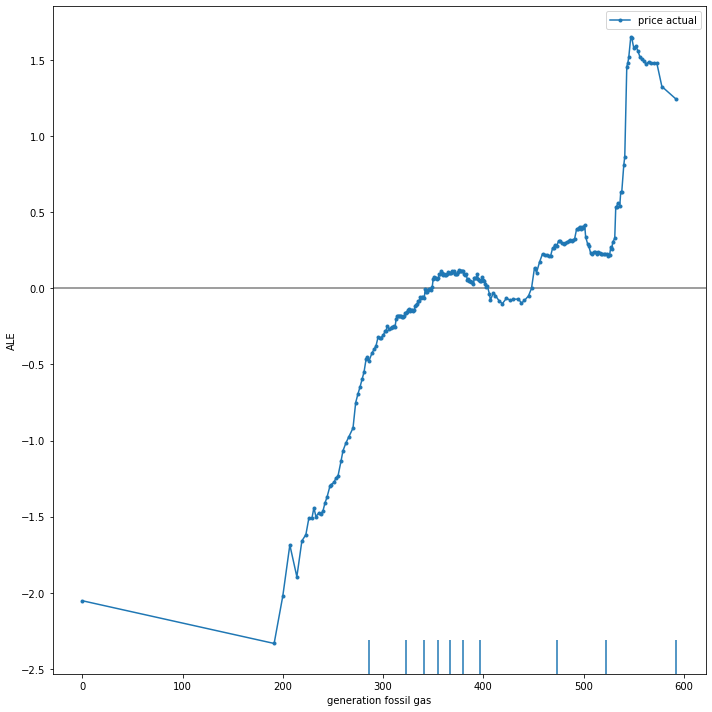

In [ ]:
# xg_ale.feature_names
plot_ale(xg_ale, fig_kw={'figwidth':10, 'figheight': 10});

### 2. Does temperature interact with the features regarding the generation of fossil oil? If so, what is the extent of interaction?

Method Used: H-statistic, feature importance

Documentation: https://pypi.org/project/sklearn-gbmi/

Example: https://github.com/ralphhaygood/sklearn-gbmi/blob/master/example.ipynb

The approach using pdpbox works.

In [ ]:
# h(grad_boost, X_train, ['temp_Barcelona', 'generation fossil brown coal/lignite'])

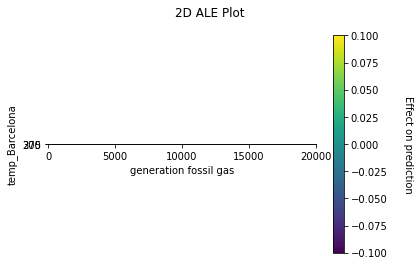

In [ ]:
ale_eff = ale(X=X_train, model=final_model, feature=["temp_Barcelona", "generation fossil gas"], grid_size=100)

#### SHAP values (Takes long to compute): https://github.com/slundberg/shap

Another option: https://docs.seldon.io/projects/alibi/en/latest/methods/KernelSHAP.html

In [ ]:
import shap

In [ ]:
shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:].values)

#### Necessary functions for pdpbox

In [ ]:

def pdp_multi_interact(model, dataset, model_features, features, 
                    num_grid_points=None, grid_types=None, percentile_ranges=None, grid_ranges=None, cust_grid_points=None, 
                    cust_grid_combos=None, use_custom_grid_combos=False,
                    memory_limit=0.5, n_jobs=1, predict_kwds=None, data_transformer=None):

    def _expand_default(x, default, length):
        if x is None:
            return [default] * length
        return x

    def _get_grid_combos(feature_grids, feature_types):
        grids = [list(feature_grid) for feature_grid in feature_grids]
        for i in range(len(feature_types)):
            if feature_types[i] == 'onehot':
                grids[i] = np.eye(len(grids[i])).astype(int).tolist()
        return np.stack(np.meshgrid(*grids), -1).reshape(-1, len(grids))

    if predict_kwds is None:
        predict_kwds = dict()

    nr_feats = len(features)

    # check function inputs
    n_classes, predict = _check_model(model=model)
    _check_dataset(df=dataset)
    _dataset = dataset.copy()

    # prepare the grid
    pdp_isolate_outs = []
    if use_custom_grid_combos:
        grid_combos = cust_grid_combos
        feature_grids = []
        feature_types = []
    else:
        num_grid_points = _expand_default(x=num_grid_points, default=10, length=nr_feats)
        grid_types = _expand_default(x=grid_types, default='percentile', length=nr_feats)
        for i in range(nr_feats):
            _check_grid_type(grid_type=grid_types[i])

        percentile_ranges = _expand_default(x=percentile_ranges, default=None, length=nr_feats)
        for i in range(nr_feats):
            _check_percentile_range(percentile_range=percentile_ranges[i])

        grid_ranges = _expand_default(x=grid_ranges, default=None, length=nr_feats)
        cust_grid_points = _expand_default(x=cust_grid_points, default=None, length=nr_feats)

        _check_memory_limit(memory_limit=memory_limit)

        pdp_isolate_outs = []
        for idx in range(nr_feats):
            pdp_isolate_out = pdp_isolate(
                model=model, dataset=_dataset, model_features=model_features, feature=features[idx],
                num_grid_points=num_grid_points[idx], grid_type=grid_types[idx], percentile_range=percentile_ranges[idx],
                grid_range=grid_ranges[idx], cust_grid_points=cust_grid_points[idx], memory_limit=memory_limit,
                n_jobs=n_jobs, predict_kwds=predict_kwds, data_transformer=data_transformer)
            pdp_isolate_outs.append(pdp_isolate_out)

        if n_classes > 2:
            feature_grids = [pdp_isolate_outs[i][0].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i][0].feature_type  for i in range(nr_feats)]
        else:
            feature_grids = [pdp_isolate_outs[i].feature_grids for i in range(nr_feats)]
            feature_types = [pdp_isolate_outs[i].feature_type  for i in range(nr_feats)]

        grid_combos = _get_grid_combos(feature_grids, feature_types)

    feature_list = []
    for i in range(nr_feats):
        feature_list.extend(_make_list(features[i]))

    # Parallel calculate ICE lines
    true_n_jobs = _calc_memory_usage(
        df=_dataset, total_units=len(grid_combos), n_jobs=n_jobs, memory_limit=memory_limit)

    grid_results = Parallel(n_jobs=true_n_jobs)(delayed(_calc_ice_lines_inter)(
        grid_combo, data=_dataset, model=model, model_features=model_features, n_classes=n_classes,
        feature_list=feature_list, predict_kwds=predict_kwds, data_transformer=data_transformer)
                                                for grid_combo in grid_combos)

    ice_lines = pd.concat(grid_results, axis=0).reset_index(drop=True)
    pdp = ice_lines.groupby(feature_list, as_index=False).mean()

    # combine the final results
    pdp_interact_params = {'n_classes': n_classes, 
                        'features': features, 
                        'feature_types': feature_types,
                        'feature_grids': feature_grids}
    if n_classes > 2:
        pdp_interact_out = []
        for n_class in range(n_classes):
            _pdp = pdp[feature_list + ['class_%d_preds' % n_class]].rename(
                columns={'class_%d_preds' % n_class: 'preds'})
            pdp_interact_out.append(
                PDPInteract(which_class=n_class,
                            pdp_isolate_outs=[pdp_isolate_outs[i][n_class] for i in range(nr_feats)],
                            pdp=_pdp, **pdp_interact_params))
    else:
        pdp_interact_out = PDPInteract(
            which_class=None, pdp_isolate_outs=pdp_isolate_outs, pdp=pdp, **pdp_interact_params)

    return pdp_interact_out

In [ ]:
def center(arr): return arr - np.mean(arr)

def compute_f_vals(mdl, X, features, selectedfeatures, num_grid_points=10, use_data_grid=False):
    f_vals = {}
    data_grid = None
    if use_data_grid:
        data_grid = X[selectedfeatures].values
    # Calculate partial dependencies for full feature set
    p_full = pdp_multi_interact(mdl, X, features, selectedfeatures, 
                                num_grid_points=[num_grid_points] * len(selectedfeatures),
                                cust_grid_combos=data_grid,
                                use_custom_grid_combos=use_data_grid)
    f_vals[tuple(selectedfeatures)] = center(p_full.pdp.preds.values)
    grid = p_full.pdp.drop('preds', axis=1)
    # Calculate partial dependencies for [1..SFL-1]
    for n in range(1, len(selectedfeatures)):
        for subsetfeatures in itertools.combinations(selectedfeatures, n):
            if use_data_grid:
                data_grid = X[list(subsetfeatures)].values
            p_partial = pdp_multi_interact(mdl, X, features, subsetfeatures, 
                                        num_grid_points=[num_grid_points] * len(selectedfeatures),
                                        cust_grid_combos=data_grid,
                                        use_custom_grid_combos=use_data_grid)
            p_joined = pd.merge(grid, p_partial.pdp, how='left')
            f_vals[tuple(subsetfeatures)] = center(p_joined.preds.values)
    return f_vals

def compute_h_val(f_vals, selectedfeatures):
    denom_els = f_vals[tuple(selectedfeatures)].copy()
    numer_els = f_vals[tuple(selectedfeatures)].copy()
    sign = -1.0
    for n in range(len(selectedfeatures)-1, 0, -1):
        for subfeatures in itertools.combinations(selectedfeatures, n):
            numer_els += sign * f_vals[tuple(subfeatures)]
        sign *= -1.0
    numer = np.sum(numer_els**2)
    denom = np.sum(denom_els**2)
    return math.sqrt(numer/denom) if numer < denom else np.nan


#### H-Statistic (Using pdpbox)

H(j,k) score for two features **j , k** from the Train Dataset 


Implementation: https://blog.macuyiko.com/post/2019/discovering-interaction-effects-in-ensemble-models.html

In [ ]:
# !pip install pdpbox

In [ ]:
# selected_features = get_weather_for_cities('temp') + ['generation']

In [ ]:
h_val_all = {feat:[] for feat in get_weather_for_cities('temp')}
for feature in get_weather_for_cities('temp'):
  print(feature)
  f_vals = compute_f_vals(xgb_model, X_train, X_train.columns, [feature, 'generation fossil gas'])
  h_val_all[feature] = compute_h_val(f_vals, [feature, 'generation fossil gas'])

temp_Barcelona
temp_Madrid
temp_Seville
temp_Bilbao
temp_Valencia


In [ ]:
h_val_all = {k: [v] for k,v in h_val_all.items()}

<AxesSubplot:>

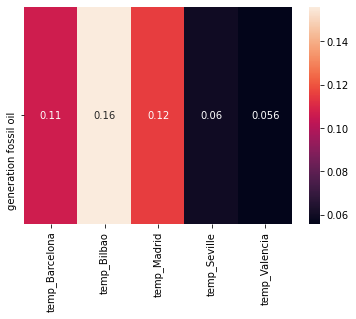

In [ ]:
h_val_all = {'temp_Barcelona': [0.10682398696117103],'temp_Bilbao': [0.15589987149841955], 'temp_Madrid': [0.11537725271043658], 'temp_Seville': [0.060026194974961415], 'temp_Valencia': [0.055739032302529384]}
h_pd = pd.DataFrame.from_dict(h_val_all)
h_pd = h_pd.rename(index={0: 'generation fossil oil'})
sn.heatmap(h_pd, annot=True)

{'temp_Barcelona': 0.10682398696117103,
 'temp_Bilbao': 0.15589987149841955,
 'temp_Madrid': 0.11537725271043658,
 'temp_Seville': 0.060026194974961415,
 'temp_Valencia': 0.055739032302529384}

#### PDP Interaction plot

In [ ]:
selected_features =  get_weather_for_cities('temp') + ['generation fossil oil']

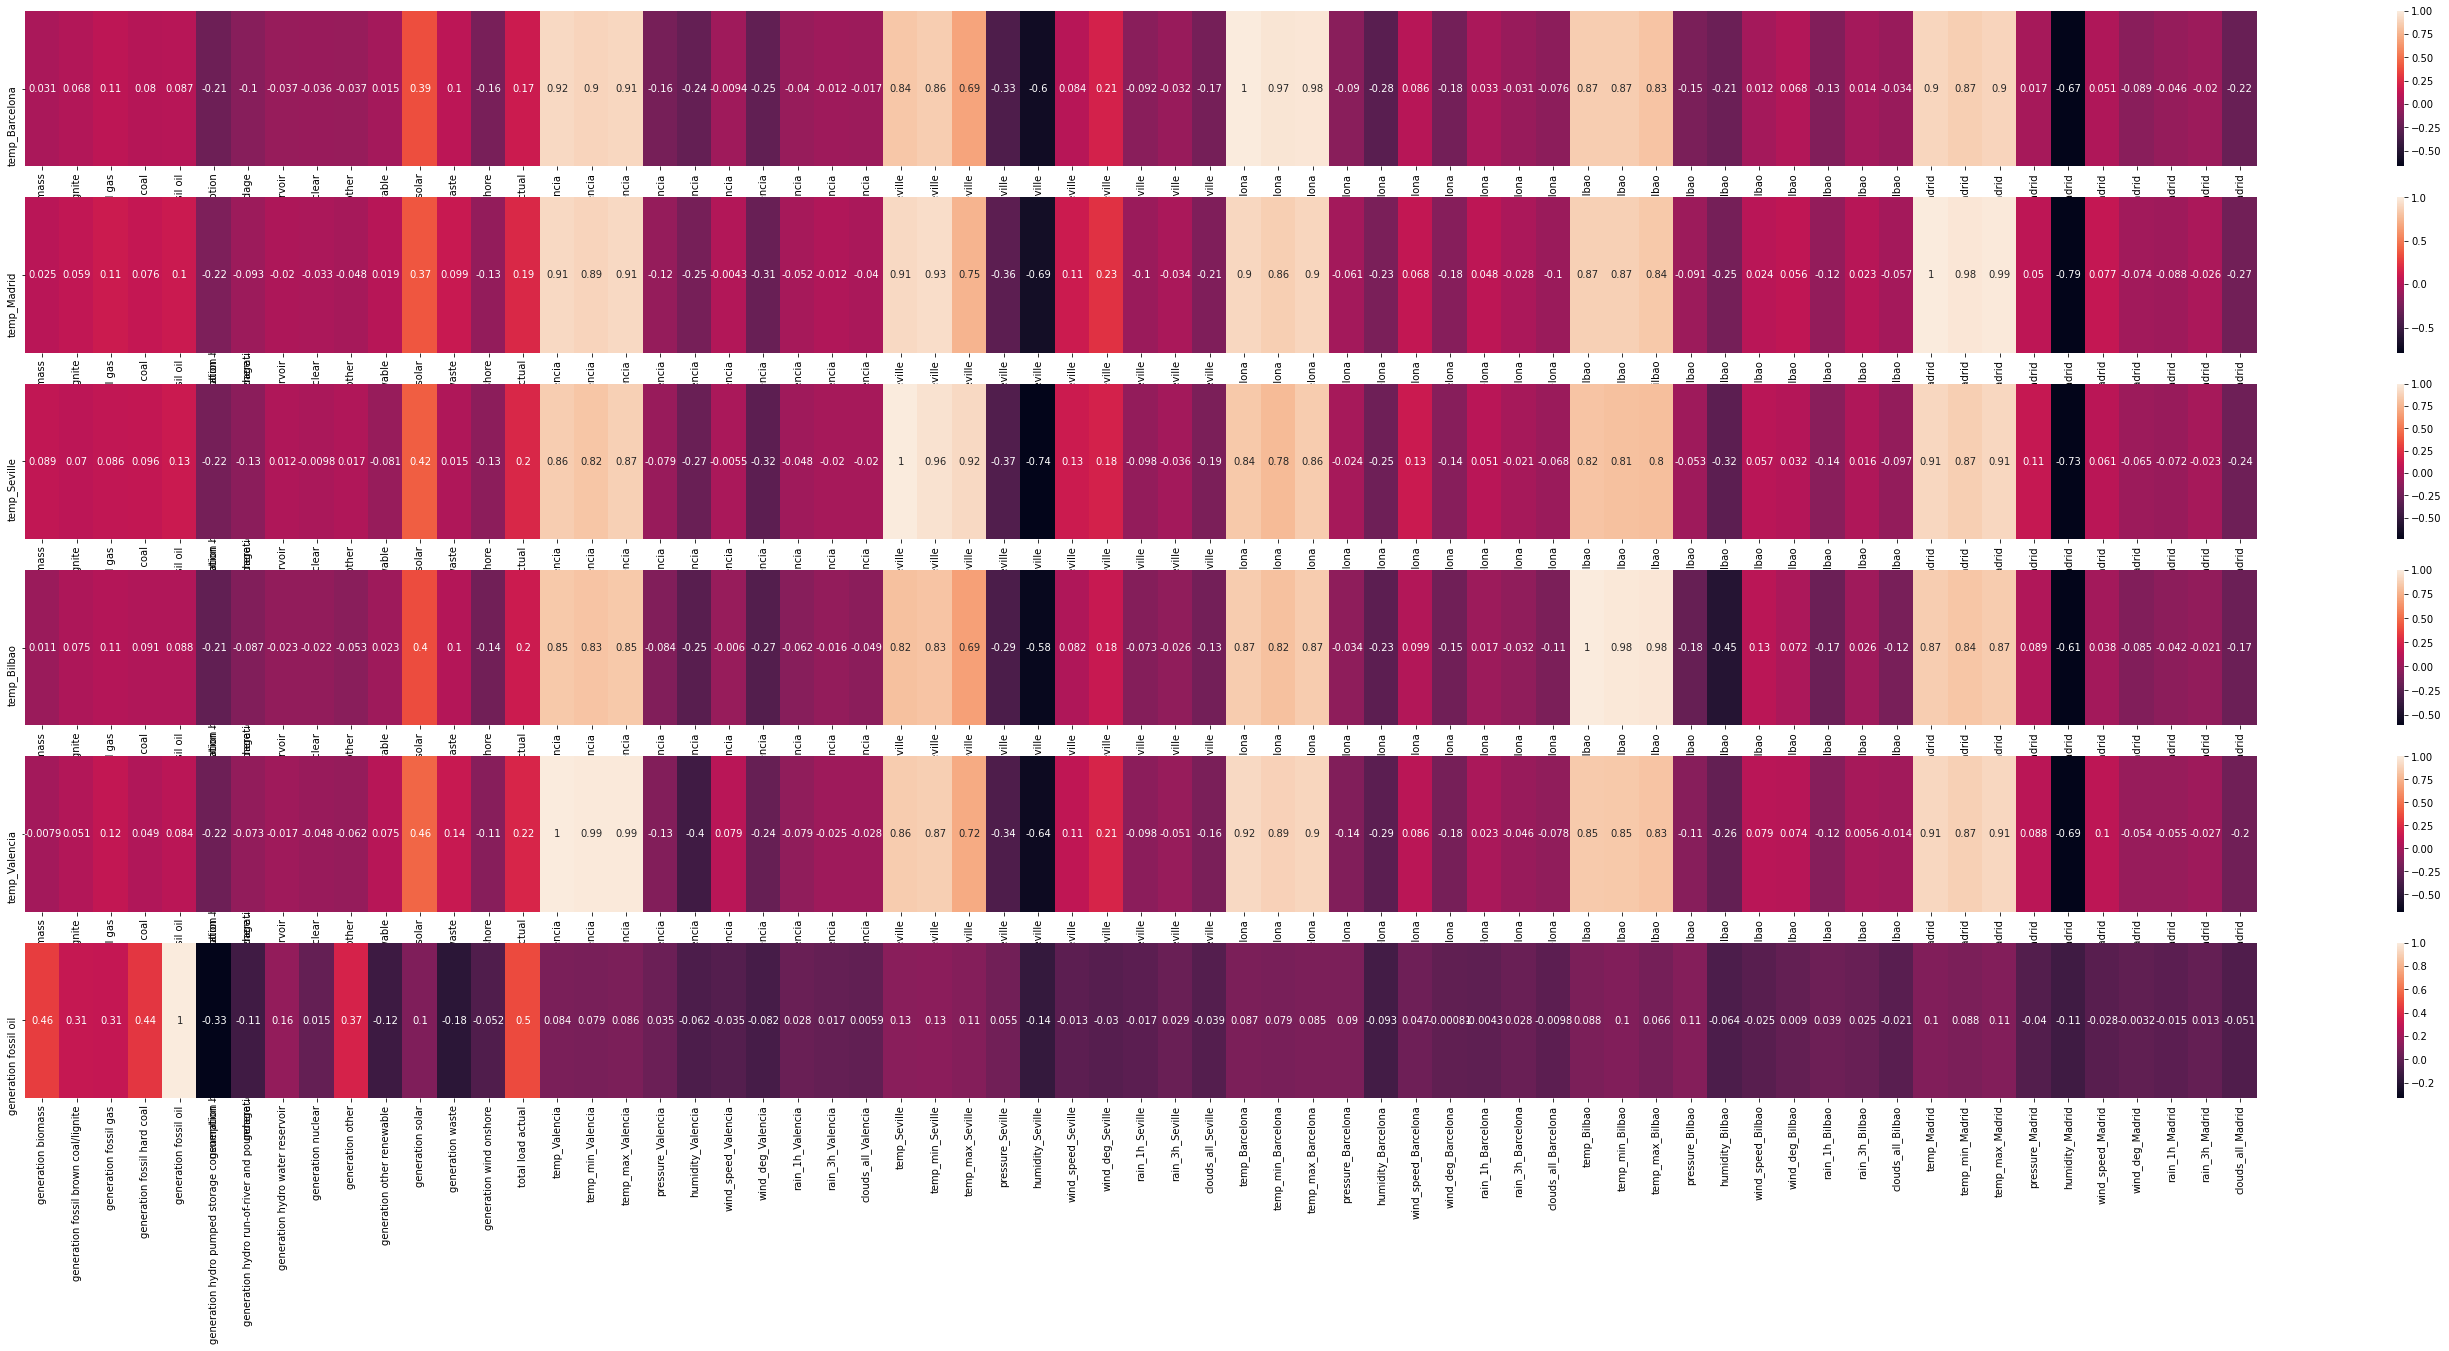

In [ ]:
# Corelation of all the concerned features with the rest of the variables
fig = plt.figure(figsize=(50,20))
gs = GridSpec(6,1, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])
ax4 = fig.add_subplot(gs[3,:])
ax5 = fig.add_subplot(gs[4,:])
ax6 = fig.add_subplot(gs[5,:])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, feature in enumerate(selected_features):
  corr_feature = corr_matrix.loc[[feature]]
  sn.heatmap(corr_feature, annot=True, ax=axes[i])

# fig


In [ ]:
pdp_multi_interactions = []
for feature in selected_features:
  if not feature == 'generation fossil oil':
    print(feature)
    pdp_multi_interactions.append(pdp_multi_interact(final_model, X_train, X_train.columns, [feature, 'generation fossil oil']))    

temp_Barcelona
temp_Madrid
temp_Seville
temp_Bilbao
temp_Valencia


clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'


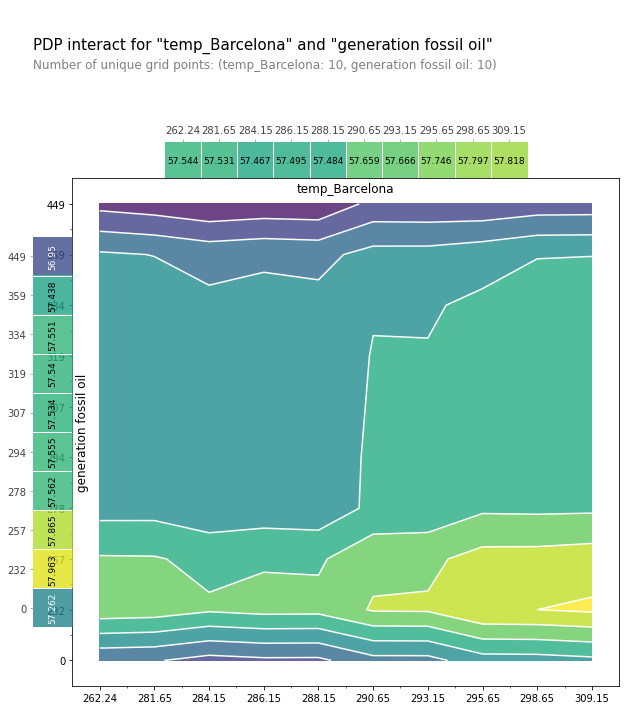

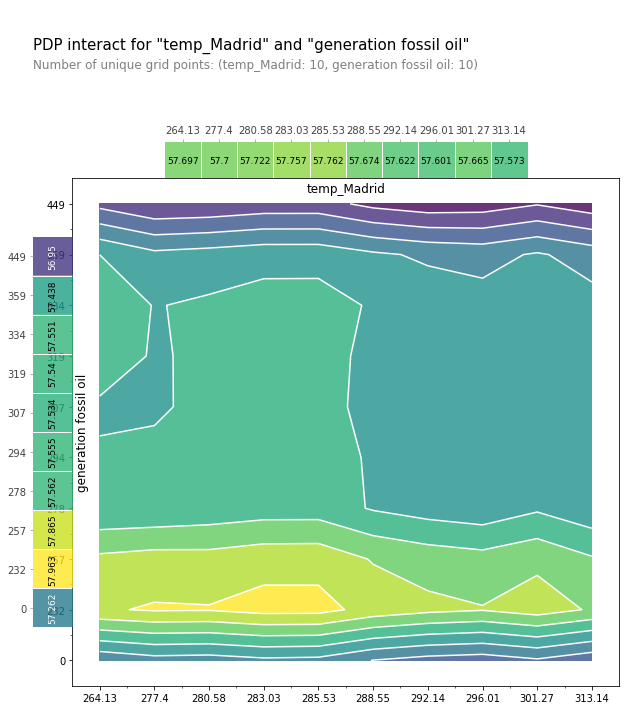

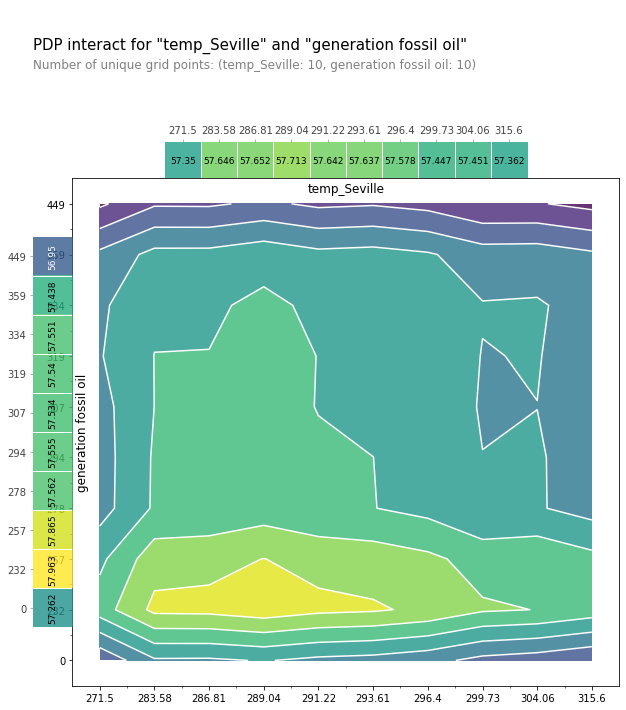

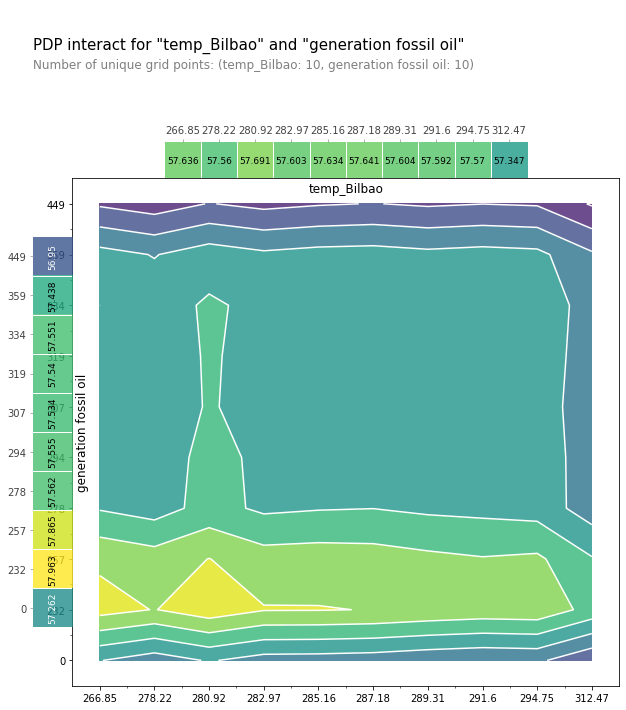

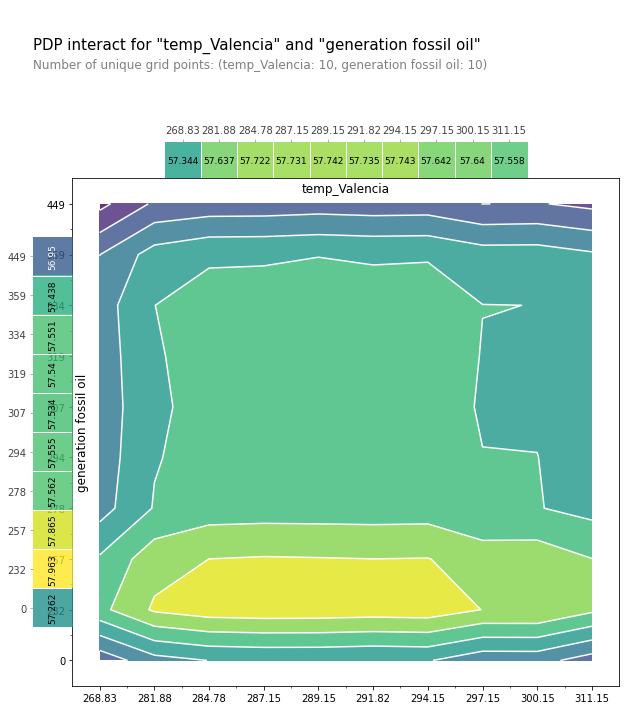

In [ ]:
for i, pdp_multi in enumerate(pdp_multi_interactions):
  try:
      fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_multi, feature_names= [selected_features[i], 'generation fossil oil'], plot_type='contour', x_quantile=True, plot_pdp=True)
  except TypeError as e:
      print(e)

### 3. How would the price actual be affected on average by the generation solar, generation fossil gas?

Method used: Partial Dependence Plot and/or Accumulated Local Effects (ALE)

Documentation: https://scikit-learn.org/stable/modules/partial_dependence.html

https://docs.seldon.io/projects/alibi/en/latest/examples/ale_regression_boston.html

ALE: https://github.com/DanaJomar/PyALE
Based on the R implementation of the same.

Final Library used: pdpbox, PyALE

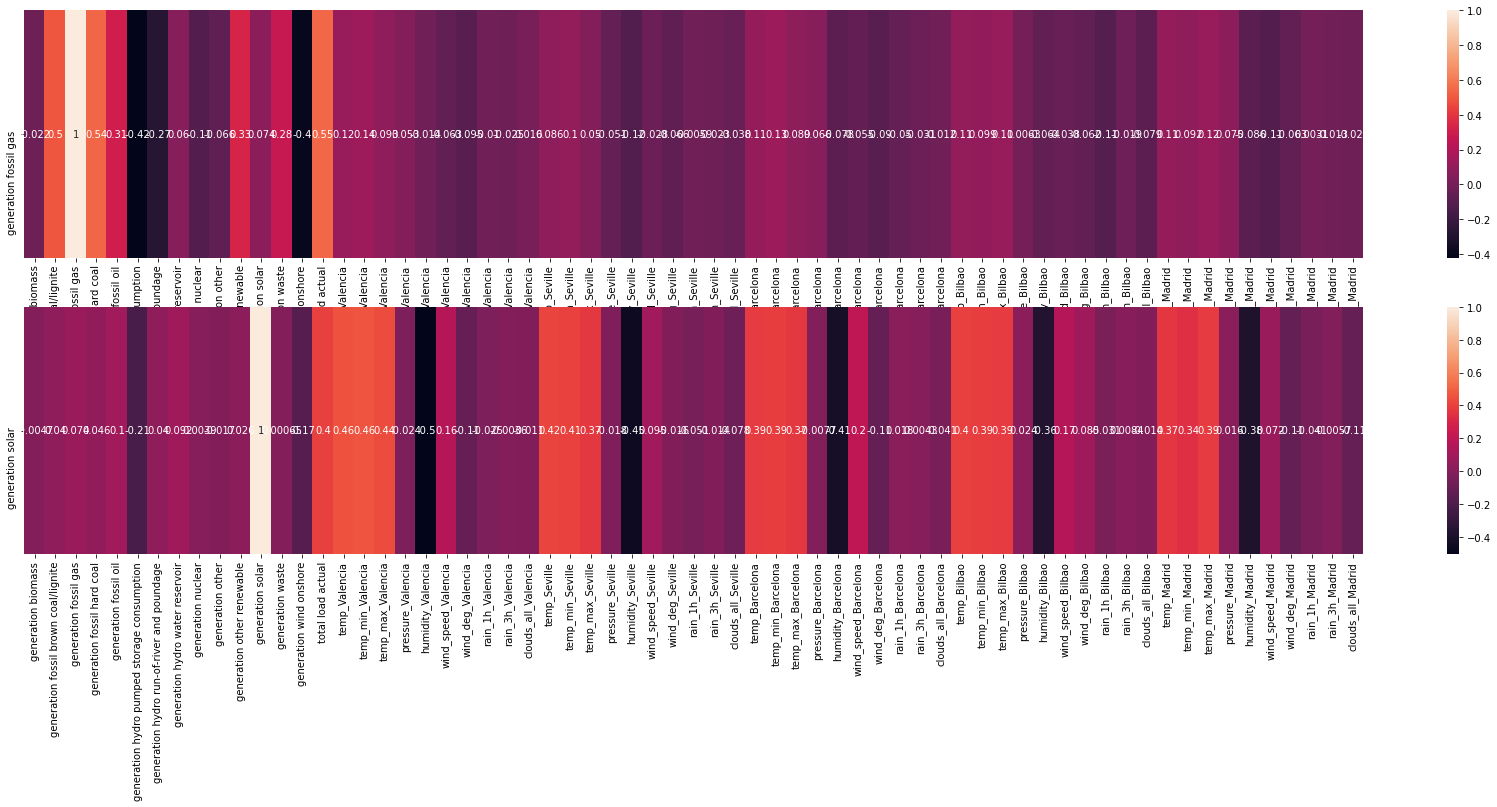

In [ ]:
# Corelation of all the concerned features with the rest of the variables
selected_features_3 = ['generation fossil gas', 'generation solar']

fig = plt.figure(figsize=(30,10))
gs = GridSpec(2,1, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])

axes = [ax1, ax2]

for i, feature in enumerate(selected_features_3):
  corr_feature = corr_matrix.loc[[feature]]
  sn.heatmap(corr_feature, annot=True, ax=axes[i])

In [ ]:
input_feat = 'generation fossil gas'

#### PDP

In [ ]:
pdp_plot = pdp.pdp_isolate(final_model, X_train, X_train.columns, input_feat)

matplotlib.font_manager:WARNING: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
matplotlib.font_manager:WARNING: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


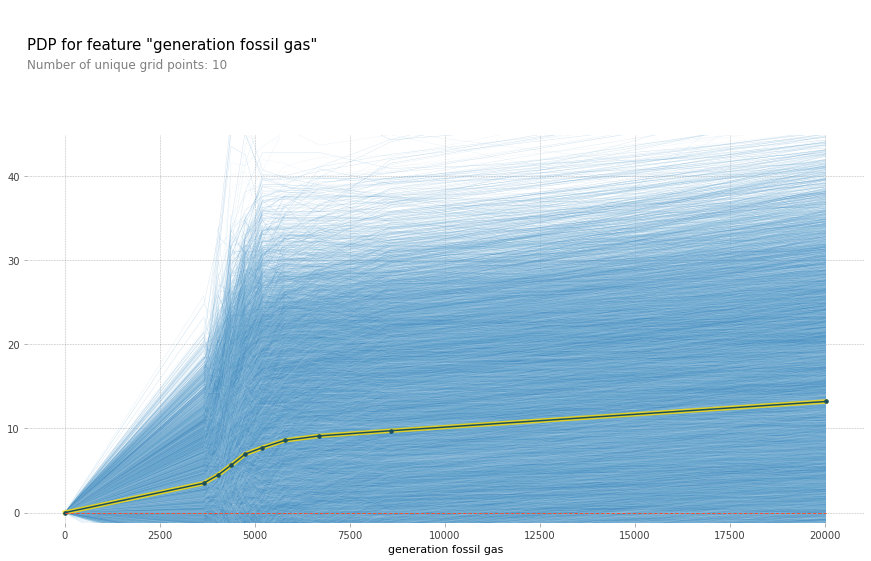

In [ ]:
fig, axes = pdp.pdp_plot(pdp_plot, input_feat, plot_lines=True)

In [ ]:
# plot_partial_dependence(xgb_model, X_train, features)

NameError: ignored

#### ALE

PyALE._ALE_generic:INFO: Continuous feature detected.


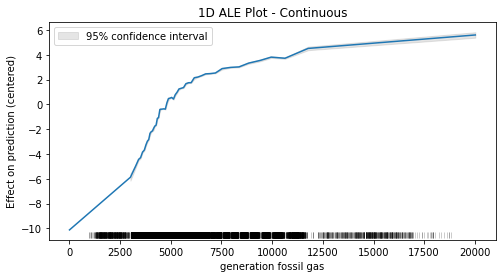

In [ ]:
ale_eff = ale(
    X=X_train, model=final_model, feature=[input_feat], grid_size=50, include_CI=True, C=0.95
)

### 4. How would the individual data instances’ price actual react to change in humidity and wind speed?


Documentation: https://scikit-learn.org/stable/modules/partial_dependence.html

In [ ]:
print(usable_features)

['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price day ahead', 'price actual', 'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia', 'rain_3h_Valencia', 'clouds_all_Valencia', 'temp_Seville', 'temp_min_Seville', 'temp_max_Seville', 'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville', 'wind_deg_Seville', 'rain_1h_Seville', 'rain_3h_Seville', 'clouds_all_Seville', 'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelon

In [ ]:
input_feat_4 = get_weather_for_cities('wind_speed')
input_feat_4

['wind_speed_Barcelona',
 'wind_speed_Madrid',
 'wind_speed_Seville',
 'wind_speed_Bilbao',
 'wind_speed_Valencia']

In [ ]:
# Corelation of all the concerned features with the rest of the variables
selected_features_3 = ['generation fossil gas', 'generation solar']

fig = plt.figure(figsize=(30,10))
gs = GridSpec(2,1, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])

axes = [ax1, ax2]

for i, feature in enumerate(selected_features_3):
  corr_feature = corr_matrix.loc[[feature]]
  sn.heatmap(corr_feature, annot=True, ax=axes[i])

#### ALE Plots


In [ ]:
X_train.describe()

generation biomass  ...  clouds_all_Madrid
count        26298.000000  ...       26298.000000
mean           383.879784  ...          20.704274
std             85.498444  ...          29.696407
min              0.000000  ...           0.000000
25%            333.000000  ...           0.000000
50%            367.000000  ...           0.000000
75%            435.000000  ...          40.000000
max            592.000000  ...         100.000000

[8 rows x 65 columns]

In [ ]:
selected_features_4 = get_weather_for_cities('wind_speed')
selected_features_4

['wind_speed_Barcelona',
 'wind_speed_Madrid',
 'wind_speed_Seville',
 'wind_speed_Bilbao',
 'wind_speed_Valencia']

In [ ]:
# ale_eff = ale(X=X_train, model=final_model, feature=['wind_speed_Barcelona'], grid_size=100, feature_type='continuous')

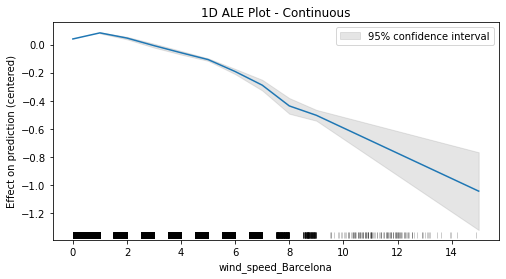

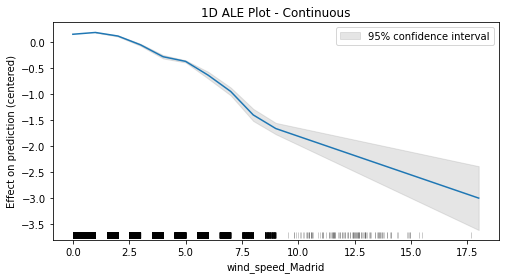

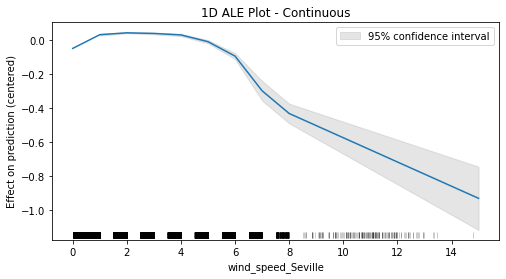

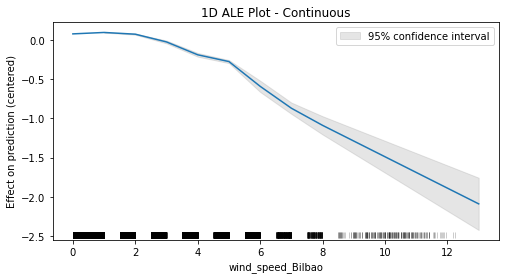

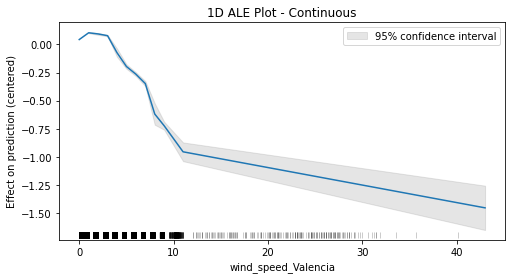

In [ ]:
for i, feat in enumerate(selected_features_4):
  ale_eff = ale(X=X_train, model=final_model, feature=[feat], grid_size=100, feature_type='continuous')

#### ICE Plots

In [ ]:

features = get_indices_of_features(input_feat_4)

plot_partial_dependence(final_model, X_train, features, kind='both', subsample=100)
# plot_partial_dependence(xgb_regressor, X_train, features, kind="both", method='brute')
# plot_partial_dependence()


In [ ]:
pdp_plots_4 = []
for feature in input_feat_4:
  print(feature)
  pdp_plots_4.append(pdp.pdp_isolate(final_model, X_train, X_train.columns, feature))

wind_speed_Barcelona
wind_speed_Madrid
wind_speed_Seville
wind_speed_Bilbao
wind_speed_Valencia


0
1
2
3
4


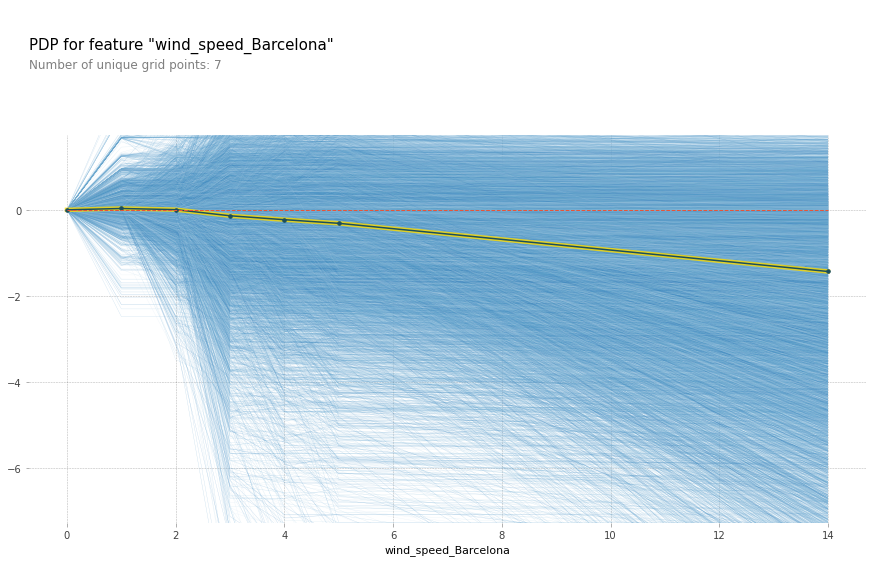

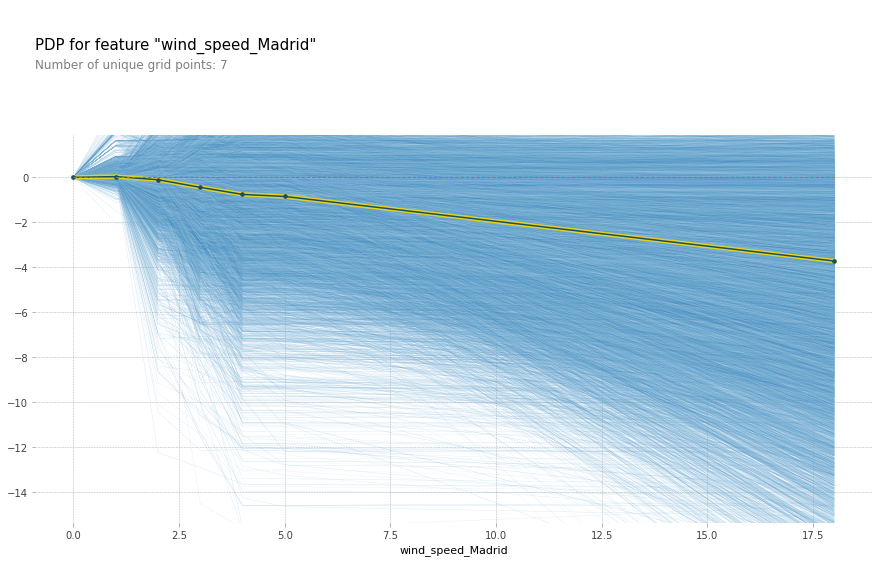

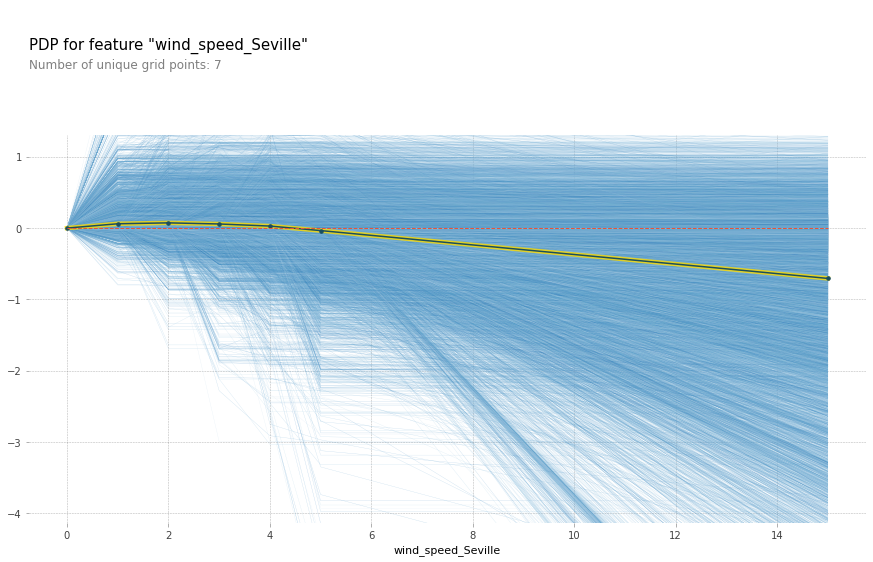

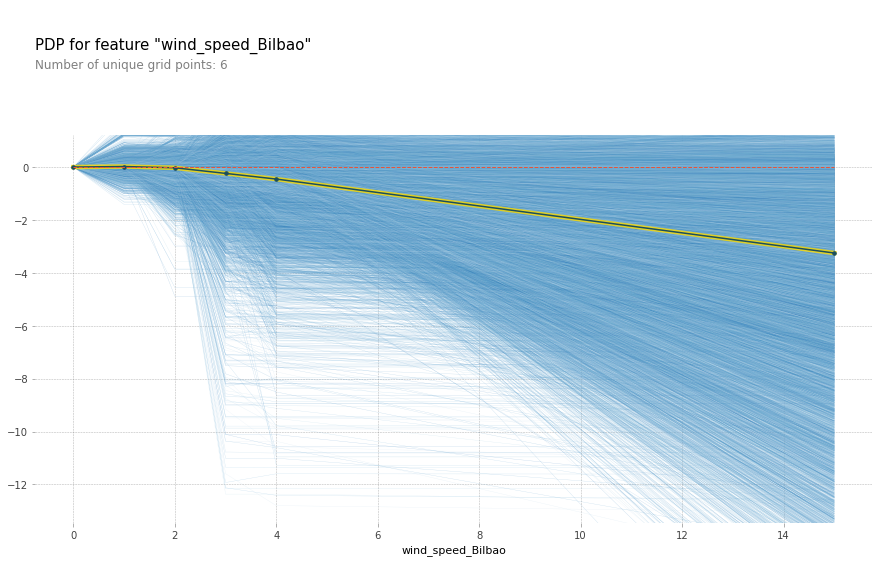

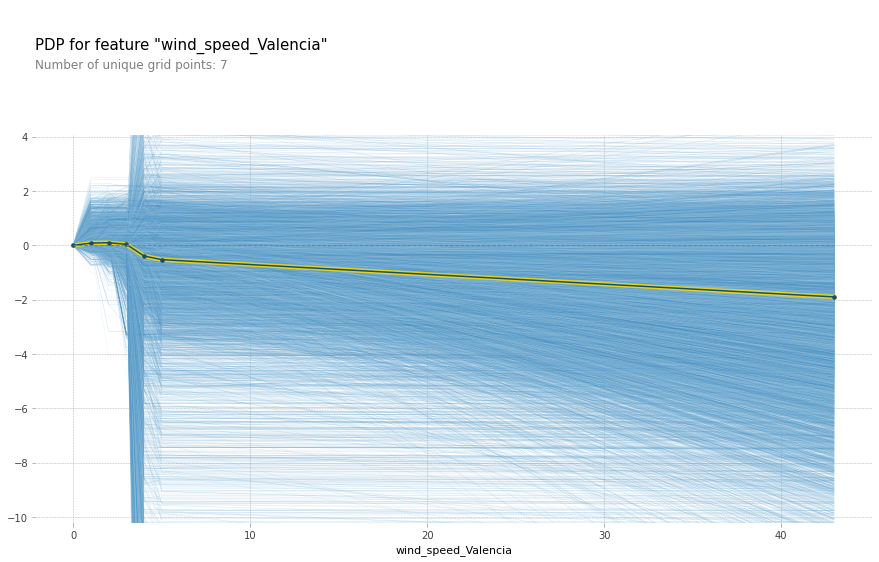

In [ ]:
for i, pdp_plot in enumerate(pdp_plots_4):
  print(i)
  fig, axes = pdp.pdp_plot(pdp_plot, input_feat_4[i], plot_lines=True)

### 5. At least how much should the generation biomass change to have the price actual for observation z below the mean? 

Possible methods:

1. https://github.com/amirhk/mace
2. https://github.com/SeldonIO/alibi

### 6. Do the clouds have an impact on the generated solar? Are they useful for predicting actual price?

In [ ]:
usable_features

In [ ]:
selected_features_6 = get_weather_for_cities('clouds_all')

#### H-Statistic

In [ ]:
h_val_all_6 = {feat:[] for feat in selected_features_6}
for feature in selected_features_6:
  print(feature)
  f_vals = compute_f_vals(final_model, X_train, X_train.columns, [feature, 'generation solar'])
  h_val_all_6[feature] = compute_h_val(f_vals, [feature, 'generation solar'])

clouds_all_Barcelona
clouds_all_Madrid
clouds_all_Seville
clouds_all_Bilbao
clouds_all_Valencia


In [ ]:
h_val_all_6 = {k: [v] for k,v in h_val_all_6.items()}

<AxesSubplot:>

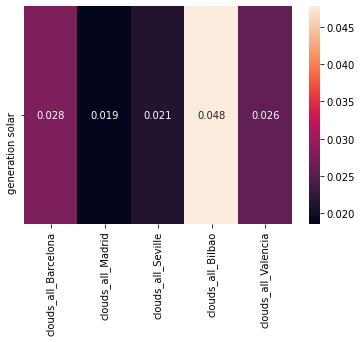

In [ ]:
h_pd = pd.DataFrame.from_dict(h_val_all_6)
h_pd = h_pd.rename(index={0: 'generation solar'})
sn.heatmap(h_pd, annot=True)

#### ALE Plots

In [ ]:
# !git clone https://github.com/MaximeJumelle/ALEPython.git
# !pip install -e "ALEPython[test]"

In [ ]:
# !pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [ ]:
# from alepython import ale_plot

PyALE._ALE_generic:INFO: Continuous feature detected.


['clouds_all_Barcelona', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Bilbao', 'clouds_all_Valencia']


PyALE._ALE_generic:INFO: Continuous feature detected.


KeyboardInterrupt: ignored

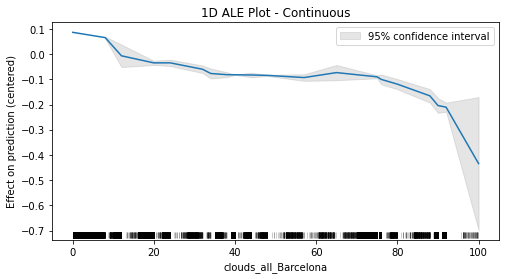

In [ ]:
# fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15, 7))
print(selected_features_6)
for i, feat in enumerate(selected_features_6):
  ale_eff = ale(X=X_train, model=final_model, feature=[feat], grid_size=100)

#### PDP Interaction

In [ ]:
selected_features_6

['clouds_all_Barcelona',
 'clouds_all_Madrid',
 'clouds_all_Seville',
 'clouds_all_Bilbao',
 'clouds_all_Valencia']

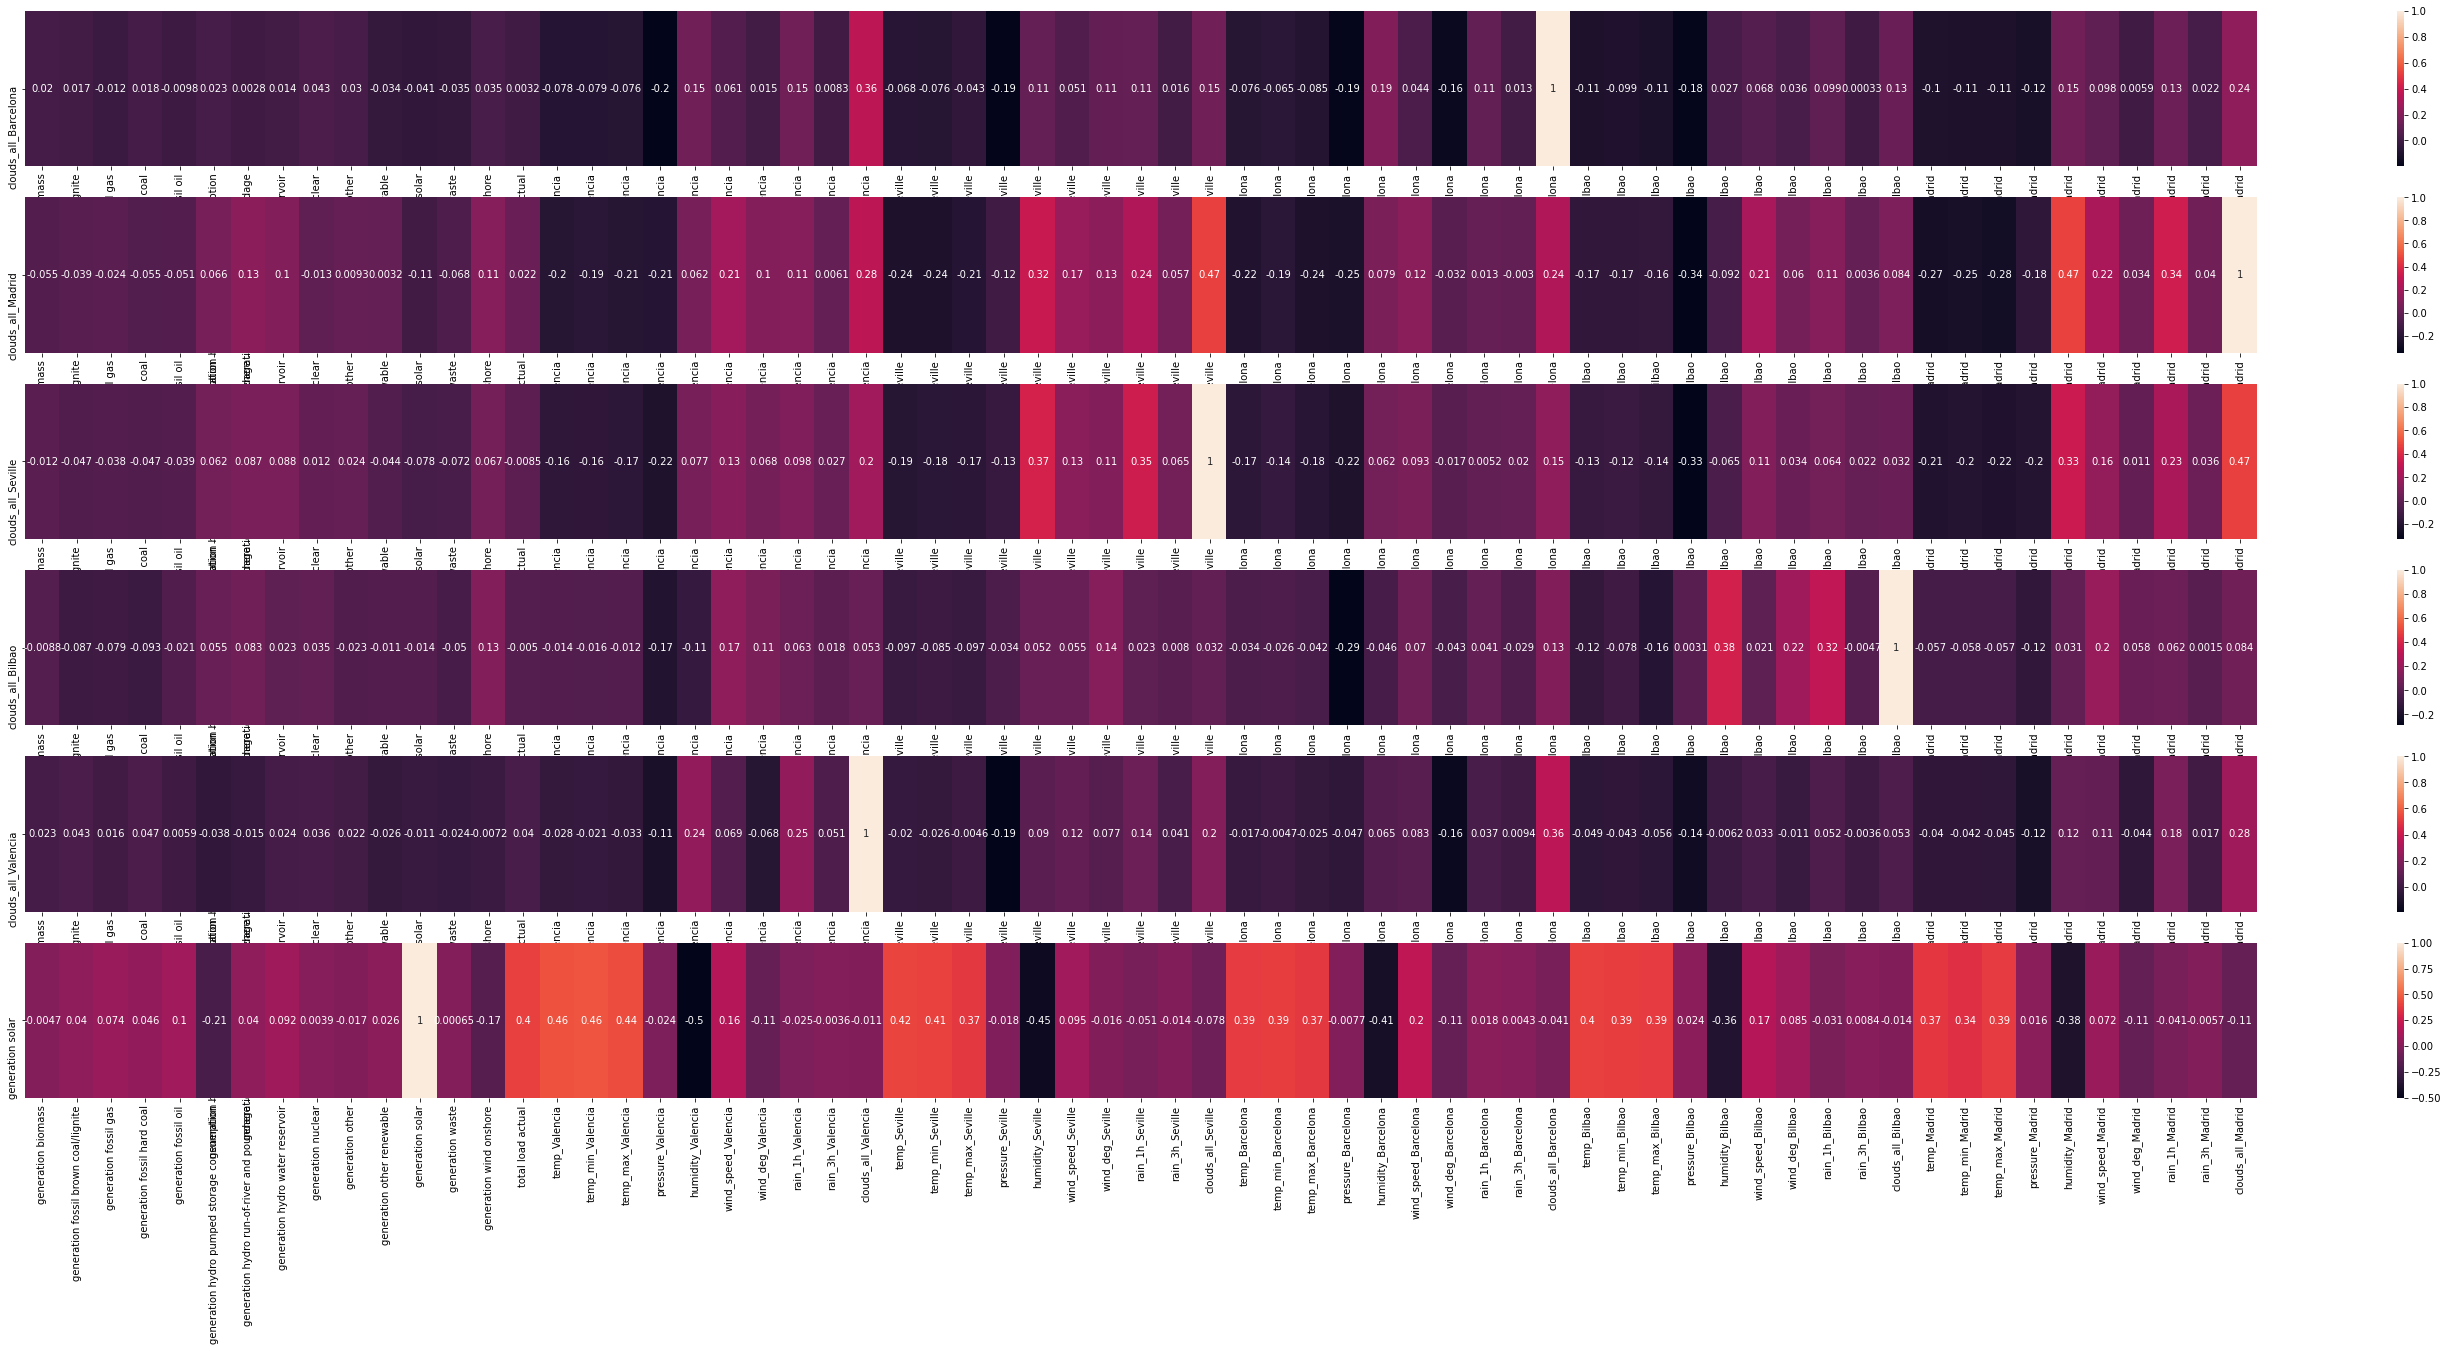

In [ ]:
# Corelation of all the concerned features with the rest of the variables
fig = plt.figure(figsize=(50,20))
gs = GridSpec(6,1, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2,:])
ax4 = fig.add_subplot(gs[3,:])
ax5 = fig.add_subplot(gs[4,:])
ax6 = fig.add_subplot(gs[5,:])
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, feature in enumerate(selected_features_6 + ['generation solar']):
  corr_feature = corr_matrix.loc[[feature]]
  sn.heatmap(corr_feature, annot=True, ax=axes[i])


In [ ]:
pdp_multi_interactions = []
for feature in selected_features_6:
  if not feature == 'generation fossil oil':
    print(feature)
    pdp_multi_interactions.append(pdp_multi_interact(final_model, X_train, X_train.columns, [feature, 'generation solar']))    

clouds_all_Barcelona
clouds_all_Madrid
clouds_all_Seville
clouds_all_Bilbao
clouds_all_Valencia


clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'


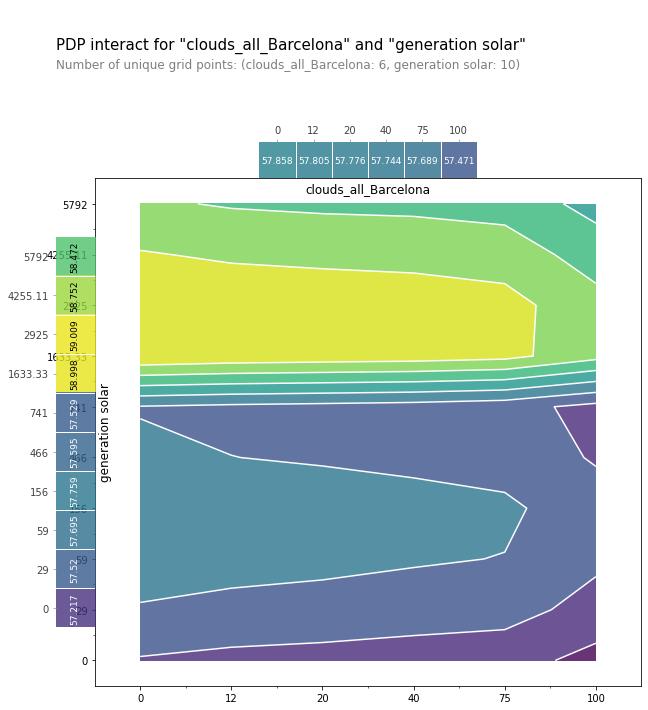

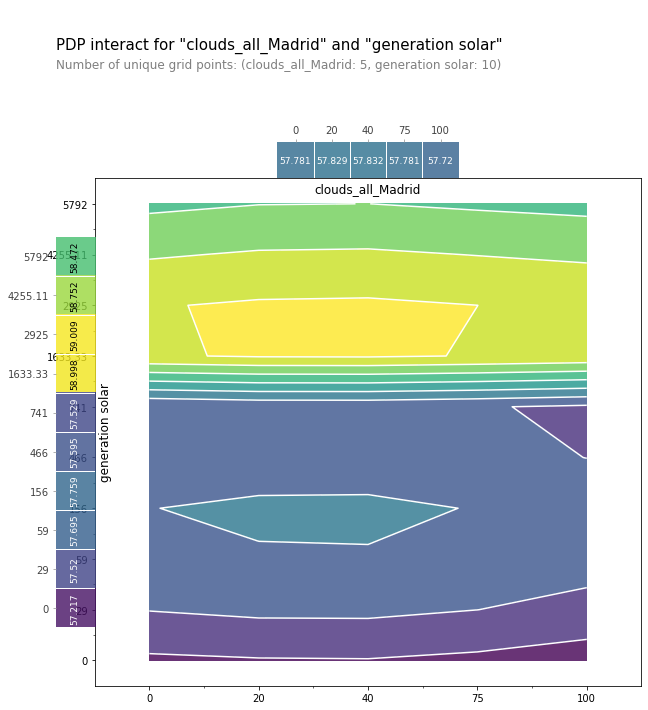

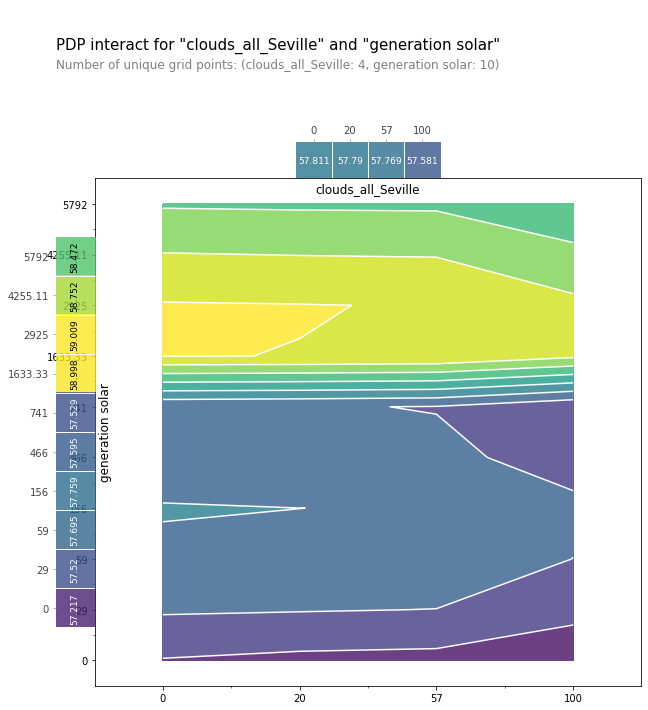

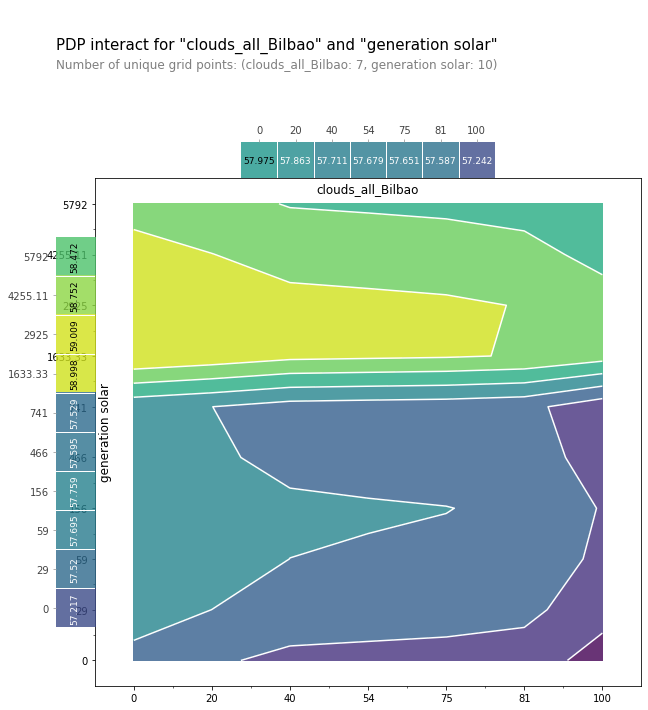

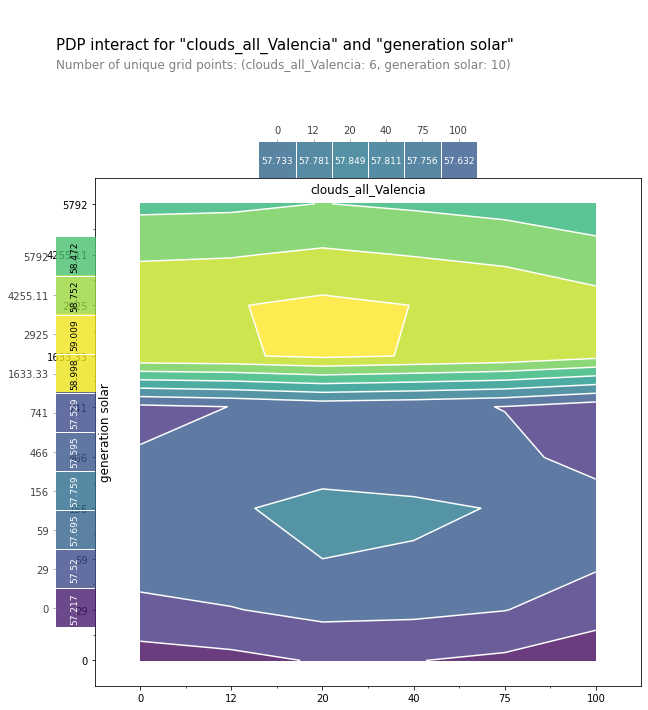

In [ ]:
for i, pdp_multi in enumerate(pdp_multi_interactions):
  try:
      fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_multi, feature_names= [selected_features_6[i], 'generation solar'], plot_type='contour', x_quantile=True, plot_pdp=True)
  except TypeError as e:
      print(e)

### 7. Does the weather in different cities impact total load actual differently?

We will take the 3 most important weather features from each city and compare how they interact with 'total load actual'. We will compare 'pressure', 'wind' and 'temp_max' from each city since they had the highest Permutation Feature Importance score.

In [ ]:
# weather_features = ['pressure', 'humidity', 'temp_max']
weather_features = ['wind_speed']

#### PDP Interaction Plots

In [ ]:
pdp_multi_interactions = {}
pdp_multi_interactions = defaultdict(lambda:[],pdp_multi_interactions)
for feature in weather_features:
  print(feature)
  for i, city_feat in enumerate(get_weather_for_cities(feature)):
    print(i)
    pdp_multi_interactions[cities[i]].append(pdp_multi_interact(final_model, X_train, X_train.columns, [city_feat, 'total load actual']))


wind_speed
0
1
2
3
4


___________________wind_speed__________________
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'
clabel() got an unexpected keyword argument 'contour_label_fontsize'


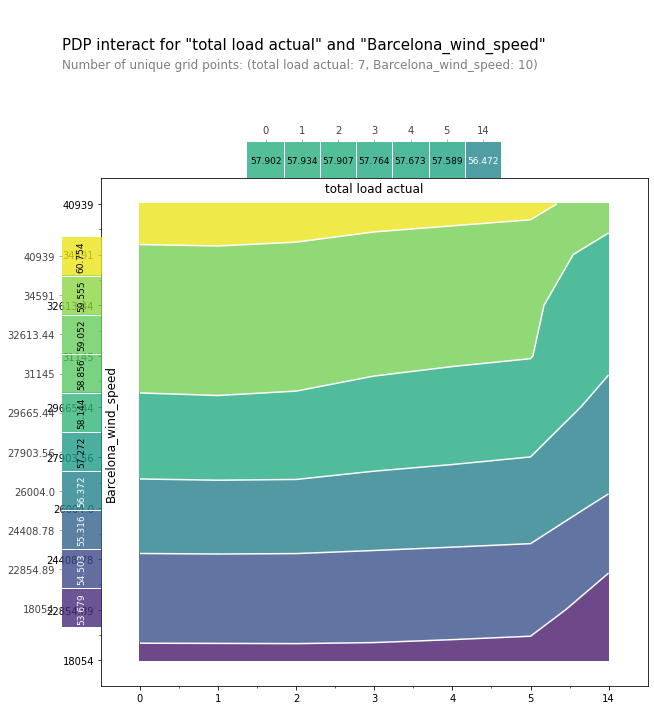

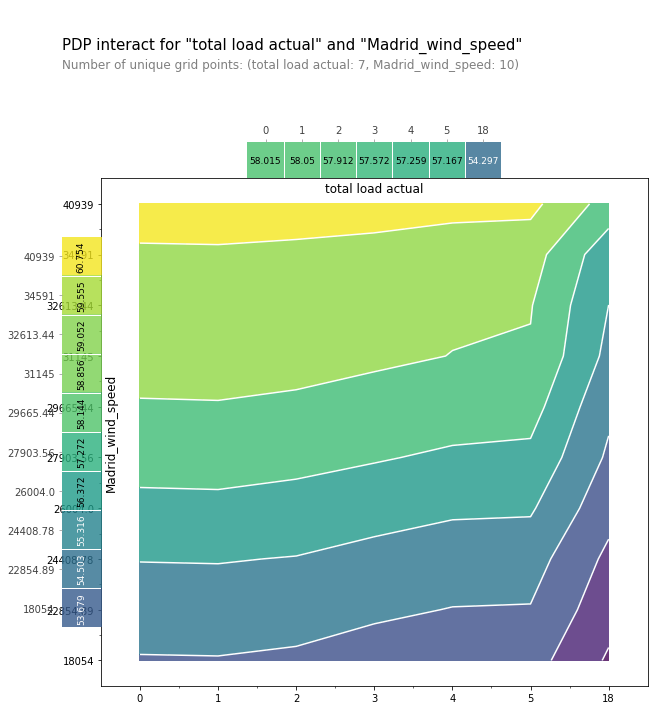

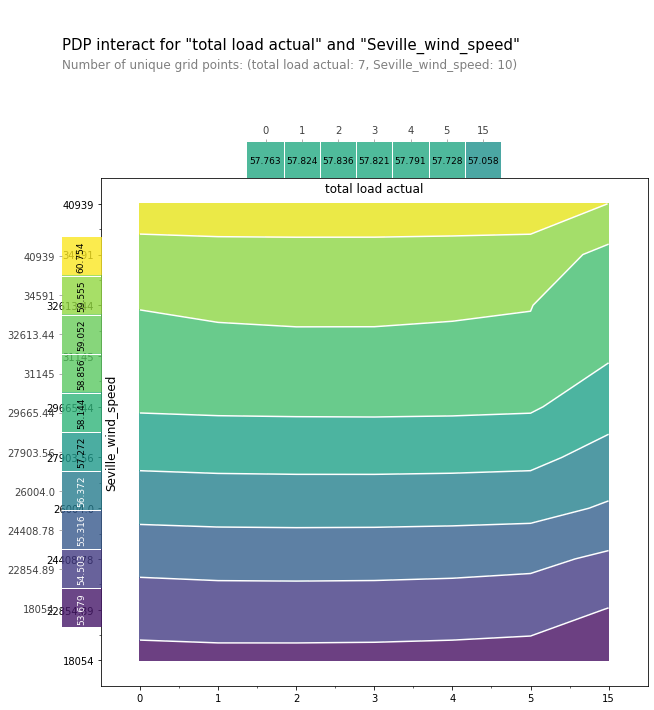

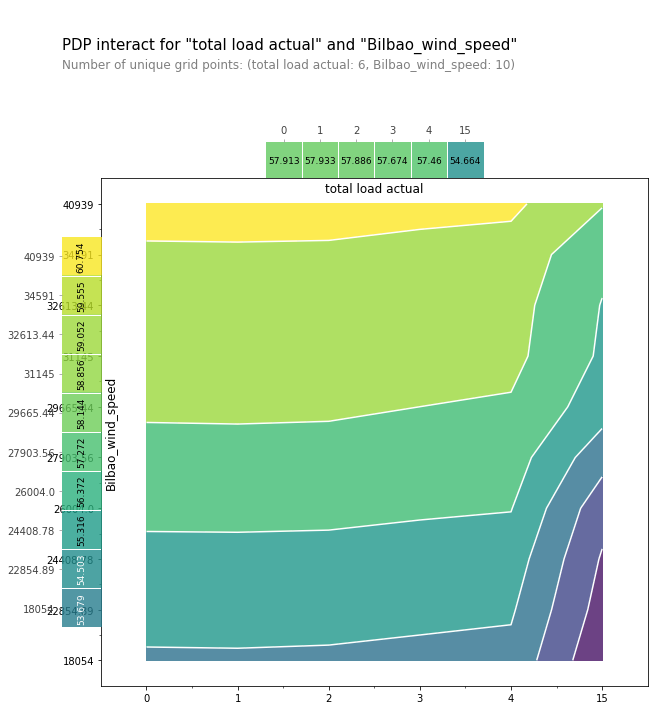

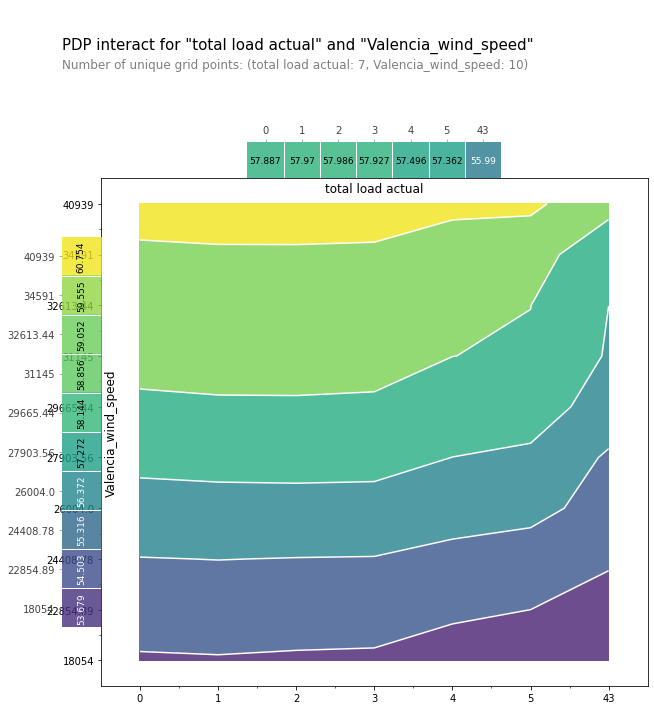

In [ ]:
for i in range(len(weather_features)):
  print("___________________{}__________________".format(weather_features[i]))
  # city_feats = get_weather_for_cities(weather_features[i])
  for city in pdp_multi_interactions.keys():
    try:
        fig, axes = pdp.pdp_interact_plot(pdp_interact_out=pdp_multi_interactions[city][i], feature_names= ['total load actual', city + '_' + weather_features[i]], plot_type='contour', x_quantile=True, plot_pdp=True)
    except TypeError as e:
        print(e)

#### H-Statistic Measures

In [ ]:
h_val_all_7 = {'Barcelona': [0.07497813084766532, 0.023307164709537476, 0.07670345116466491], 'Bilbao': [0.04963369561827833, 0.07903716032301956, 0.03741148894135837], 'Madrid': [0.07565835101106795, 0.05389517483759326, 0.013317935866522683], 'Seville': [0.07453843958784011, 0.036779778319420545, 0.1282804064194406], 'Valencia': [0.050878688057634805, 0.0426533417989776, 0.08275240706129512]}
for feature in weather_features:
  print(feature)
  for i, city_feat in enumerate(get_weather_for_cities(feature)):
    assert cities[i] in city_feat
    print(i)
    f_vals = compute_f_vals(xgb_model, X_train, X_train.columns, [city_feat, 'total load actual'])
    h_val_all_7[cities[i]].append(compute_h_val(f_vals, [city_feat, 'total load actual']))

wind_speed
0
1
2
3
4


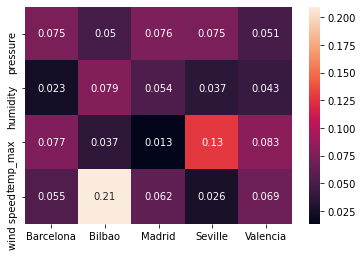

In [ ]:
h_val_all_7 = {'Barcelona': [0.07497813084766532, 0.023307164709537476, 0.07670345116466491, 0.054740756363615], 'Bilbao': [0.04963369561827833, 0.07903716032301956, 0.03741148894135837, 0.209848205110092], 'Madrid': [0.07565835101106795, 0.05389517483759326, 0.013317935866522683, 0.06244904892558871], 'Seville': [0.07453843958784011, 0.036779778319420545, 0.1282804064194406, 0.02646731861268269], 'Valencia': [0.050878688057634805, 0.0426533417989776, 0.08275240706129512, 0.06870871585834794]}

h_pd = pd.DataFrame.from_dict(h_val_all_7, orient='columns')
h_pd = h_pd.rename(index={0: 'pressure', 1: 'humidity', 2: 'temp_max', 3: 'wind speed'})
sn.heatmap(h_pd, annot=True)

{'Barcelona': [0.07497813084766532, 0.023307164709537476, 0.07670345116466491],
 'Bilbao': [0.04963369561827833, 0.07903716032301956, 0.03741148894135837],
 'Madrid': [0.07565835101106795, 0.05389517483759326, 0.013317935866522683],
 'Seville': [0.07453843958784011, 0.036779778319420545, 0.1282804064194406],
 'Valencia': [0.050878688057634805, 0.0426533417989776, 0.08275240706129512]}

 {'Barcelona': [0.07497813084766532,
  0.023307164709537476,
  0.07670345116466491,
  0.054740756363615],
 'Bilbao': [0.04963369561827833,
  0.07903716032301956,
  0.03741148894135837,
  0.209848205110092],
 'Madrid': [0.07565835101106795,
  0.05389517483759326,
  0.013317935866522683,
  0.06244904892558871],
 'Seville': [0.07453843958784011,
  0.036779778319420545,
  0.1282804064194406,
  0.02646731861268269],
 'Valencia': [0.050878688057634805,
  0.0426533417989776,
  0.08275240706129512,
  0.06870871585834794]}

### 8. Can we reduce the generation fossil (all combined) for the price actual to remain the same?

Documentation: https://github.com/marcotcr/anchor

https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_tabular_adult.html

#### Manual Attempt

#### Anchors with Binning

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from alibi.explainers import AnchorTabular
from alibi.datasets import fetch_adult

In [ ]:


n_bins = 20

est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')



data = df_final.drop(['price actual'], axis=1)
target = df_final['price actual'].values.reshape(-1, 1)
feature_names = list(data.columns)
category_map = gen_category_map(data)

targ_min = target.min().round(0)
targ_max = target.max().round(0)
bin_width = (targ_max - targ_min)/n_bins


# bins = {k: v for k in range()}
print()


est.fit(target)
target = est.transform(target)


In [ ]:
def get_bin_boundary(x):
    low = targ_min + (int(x)) * bin_width
    high = targ_min + (int(x) + 1) * bin_width
    print("The given value is between {} and {}.".format(low.round(2), high.round(2)))
    print(est.inverse_transform(x.reshape(1,-1)))
get_bin_boundary(target[238])

The given value is between 68.4 and 73.8.
[[71.12525]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])                                    

preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features), ('cat', categorical_transformer, categorical_features)])
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

In [ ]:
np.random.seed(0)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(preprocessor.transform(X_train), y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

In [ ]:
predict_fn = lambda x: clf.predict(preprocessor.transform(x))
print('Train accuracy: ', accuracy_score(y_train, predict_fn(X_train)))
print('Test accuracy: ', accuracy_score(y_test, predict_fn(X_test)))

Train accuracy:  1.0
Test accuracy:  0.6778462240474561


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


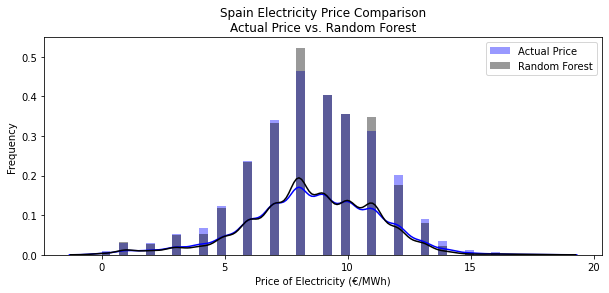

In [ ]:
plt.figure(figsize=(10,4))
# gr = sns.distplot(TSO_pred, bins=50, label='TSO Prediction',color='r')
gr = sns.distplot(y_test, label='Actual Price',color='blue')
gr = sns.distplot(predict_fn(X_test), label='Random Forest',color='black')


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
gr.set_title('Spain Electricity Price Comparison\nActual Price vs. Random Forest')
plt.legend()
plt.show()

In [ ]:
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map, seed=1)

In [ ]:
explainer.fit(X_train.values, disc_perc=[25, 50, 75])

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': [25, 50, 75], 'seed': 1}}
)

In [ ]:
idx = 100
print(est.inverse_transform(y_test[idx].reshape(1, -1)))
# class_names = 'price'
print('Prediction: ', explainer.predictor(X_test.iloc[[idx]].values))

[[65.75175]]
Prediction:  [10.]


In [ ]:
explanation = explainer.explain(X_test.iloc[[idx]].values, threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: 50.50 < price day ahead <= 60.52 AND generation other renewable > 97.00 AND generation waste <= 240.00 AND generation hydro water reservoir > 3764.00 AND wind_deg_Valencia <= 50.00 AND generation hydro pumped storage consumption <= 67.00 AND 263.00 < generation fossil oil <= 300.00 AND 28919.00 < total load actual <= 32195.00 AND wind_deg_Seville <= 175.00 AND temp_Seville <= 298.93 AND 280.15 < temp_min_Madrid <= 293.71 AND temp_max_Seville <= 303.15 AND wind_speed_Seville <= 4.00 AND temp_min_Bilbao <= 290.15 AND 282.15 < temp_max_Madrid <= 296.15 AND generation nuclear <= 6558.00 AND temp_Madrid <= 295.02 AND temp_Valencia > 285.15 AND generation fossil gas <= 6424.50 AND wind_deg_Barcelona > 100.00 AND wind_speed_Madrid <= 3.00 AND pressure_Seville <= 1023.00 AND temp_Barcelona <= 295.15 AND temp_max_Bilbao > 283.15 AND clouds_all_Valencia <= 20.00 AND rain_3h_Bilbao <= 0.00 AND humidity_Seville > 45.00
Precision: 0.95
Coverage: 0.75
